### Initialize

In [1]:
# Define Program Version 
__ver__ = '01'

In [2]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets as widgets
from IPython.display import display

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

Updating the local database...
Done


In [3]:
# Bunch of functions 

def lorentzian_fitfun(f, f0, gamma, amp=1, offset=0):
    return amp * (gamma/2)**2 / ((f-f0)**2 + (gamma/2)**2) + offset

def gaussian(x, x0, sigma, amp, offset=0): return offset + amp*np.exp(- (x-x0)**2 / (2*sigma**2))

def bin_data(xi, yi):
    x = np.unique(xi)
    y = [None] * x.size
    for i in range(x.size): y[i] = yi[xi == x[i]]
    # Return 
    y_mean = np.array([a.mean() for a in y])
    y_err = np.array([np.std(a) / (a.size**0.5) for a in y])
    return (x, y_mean, y_err, y, xi, yi)

# returns rabi in kHz
@np.vectorize
def volt2rabi(volt):
    if volt < 0.1 or volt > 5:
        return 0
    volt = np.log10(volt)
    dbm = 1.5863 +0.2211*volt -0.1022*volt**2 -0.1301*volt**3 -0.0862*volt**4 +0.2323*volt**5 +0.1624*volt**6 -0.1552*volt**7 -0.1206*volt**8
    dbm = 10**dbm
    sqrtpwr = (10**((dbm-30)/10))**(1/2)
    return -0.0332 +0.5832*sqrtpwr -0.0167*sqrtpwr**2

from scipy.optimize import brentq
# Provide rabi in kHz
@np.vectorize
def rabi2volt(rabi):
    if rabi <= volt2rabi(0.1) or rabi >= volt2rabi(5):
        print('outside valid range')
        return 0
    def funSolve(v):
        return rabi - volt2rabi(v)
    return brentq(funSolve, 0.1, 5)
def meshgrid(xLen=10, yLen=10, data=None):
    if data is not None: yLen, xLen = data.shape
    return np.meshgrid(np.arange(xLen, dtype=np.float), np.arange(yLen, dtype=np.float))
def gaussian_2d(x, y, cx=1, cy=1, sx=1, sy=1, amp=1, offset=0, angle=0):
    x, y = x - cx, y - cy
    sx, sy = 2*sx**2, 2*sy**2
    a = angle * np.pi / 180
    xp, yp = x*np.cos(a) + y*np.sin(a), - x*np.sin(a) + y*np.cos(a)
    return offset + amp * np.exp(-xp**2/sx - yp**2/sy)
    
def gaussian_2d_guess(data, x=None, y=None):
    if x is None: x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    t = np.sum(data)
    cx, cy = np.sum(data * x) / t, np.sum(data * y) / t
    sx, sy = (np.sum(data * (x-cx)**2) / t)**(1/2), (np.sum(data * (y-cy)**2) / t)**(1/2)
    return (cx, cy, sx, sy, data[int(cy), int(cx)], np.mean(data)/5, 0.0)
    
def fit_gaussian_2d(data, guess=None, plot=False):
    if guess is None: guess = gaussian_2d_guess(data)
    fr = tp.optimize.surface_fit(data, fun=gaussian_2d, guess=guess, show=plot)
    return fr
def gaussian_2d_integral(data, nsigma, fr=None, ideal=False, plot=False, guess=None, return_mask=False):
    if fr is None: fr = fit_gaussian_2d(data, guess=guess)
    # Generate the fitted data
    x, y = meshgrid(data=data)
    fit_data = gaussian_2d(x, y, *fr)
    amp = 1 if len(fr) <= 4 else fr[4]
    offset = 0 if len(fr) <= 5 else fr[5]
    # Ideal case
    if ideal:
        return np.sum(fit_data - offset)
    # Data case
    threshhold = np.exp(- nsigma**2/2) * amp + offset
    mask = fit_data >= threshhold
    # Plot
    if plot:
        plt.figure()
        plt.imshow(data)
        fit_data[~mask] = 0
        plt.imshow(mask, alpha=0.2, cmap='gray')
    
    # Mask return
    if return_mask:
        return mask
    
    return np.sum(data[mask])

''' 
Copy image names from clipboard and get parameters 
df : if you want to add on to the older df
init : initialize and return empty df
var : list of strings (variable names) that you want to retrive from database
x_var : a string (variable name), available as df.x
image_func : either tp.Image or tp.Hybrid_Image
using : 0=TopA only, 1=TopB only, 2=All Images
'''
def get_from_clipboard(df=None, init=False, var=None, x_var=None, image_func=tp.Image, using=2, display=False):
    # If initializing, then return empty dataframe
    if init: return pd.DataFrame(columns=['name','image'])
    
    # If df is None, make an empty one
    if df is None: 
        df = pd.DataFrame(columns=['name','image'])
    
    # Get the copied image names
    pasted = pd.read_clipboard(header=None, names=['name'])['name'].tolist()
    
    # Filter for using 0:TopA only, 1:TopB only, 2:all
    if using==0:
        pasted_filtered = [p for p in pasted if p[-1]=='A']
    elif using==1:
        pasted_filtered = [p for p in pasted if p[-1]=='B']
    else:
        pasted_filtered = [p for p in pasted]
    
    # Add it to df if not already in there
    names = df.name.tolist()
    for n in tqdm(pasted_filtered, desc='Loading'):
        if n not in names:
            df.loc[df.shape[0]] = n
            df.image[df.shape[0]-1] = image_func(name=n)
    
    # sort in time
    df.sort_values('name', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Get Parameters
    try: bec1db.refresh()
    except: pass
    df['shot'] = np.linspace(0,df.shape[0]/2-0.5,df.shape[0])
    if x_var is not None:
        df['x'] = bec1db.image_query(df.name.tolist(), [x_var])[x_var]
    if type(var) is str:
        df[var] = bec1db.image_query(df.name.tolist(), [var])[var]
    elif type(var) is list:
        _ = bec1db.image_query(df.name.tolist(), var)
        for n in var:
            df[n] = _[n]
    
    # Print Information
    if display:
        print('Pasted Sample : ', pasted[0:2])  
        print('Newly added images       : {}'.format(df.shape[0]- len(names)))
        print('Total number of images   : {}'.format(df.shape[0]))
    
    # return
    return df


def get_roi(data, center=[0,0], width=100, height=100):
    center = (data.shape[1]//2 + center[0], data.shape[0]//2 + center[1])
    return tp.imagedata.get_cropi(data, center=center, width=width, height=height)

def atom_num_filter(df_, keep = 0.15, offset = 0.0, plot=True):
    # Prepare
    if plot: fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
    if plot: ax[0].plot(df_['shot'], df_['total_atoms']/1e6,'.-', label='All')
    shapes = [df_.shape]
    
    # Filter
    median_numbers = np.median(df_.total_atoms)
    offset += 1
    using = (df_.total_atoms.values > median_numbers*(offset-keep)) & (df_.total_atoms.values <= median_numbers*(offset+keep))
    bad = df_[~using] 
    df_ = df_[using]
    df_.reset_index(inplace=True, drop=True)
    shapes.append(df_.shape)
    if plot: ax[0].plot(bad['shot'], bad['total_atoms']/1e6, 'rx', label='Atom Num Filter')
    if plot: ax[0].axhline(median_numbers/1e6, linestyle='--', color='k', alpha=0.5)

    if plot: 
        # Plot
        median_numbers = np.median(df_.total_atoms)
        ax[1].plot(df_['shot'], df_['total_atoms']/median_numbers,'o-')
        ax[1].axhline(1, linestyle='--', color='k', alpha=0.5)

        ax[0].legend()
        ax[0].set(title = 'Atom number stability', xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [M]')
        ax[1].set(title = 'Median Atom Num {:.2f} M'.format(median_numbers/1e6), xlabel= 'Shot Number ~ Time', ylabel='Atom Numbers [median]')
        plt.tight_layout()

        # Relevant Information
        print('''
        Total Loaded Images {}
        Atom Num Filter     {}
        Removed Images      {}
        '''.format(shapes[0][0], shapes[1][0], shapes[0][0]-shapes[1][0]))
    
    return using

def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))

def mesh_for_2d_plot(x, y, z):
    x1 = np.concatenate([ [2*x[0] - x[1]], x])
    x2 = np.concatenate([x, [2*x[-1] - x[-2]]])
    x = np.mean([x1, x2], axis=0)

    y1 = np.concatenate([ [2*y[0] - y[1]], y])
    y2 = np.concatenate([y, [2*y[-1] - y[-2]]])
    y = np.mean([y1, y2], axis=0)
    
    return (x, y, z)

def fourier_transform(curve, k):
    return np.array([np.trapz(curve.y * np.exp(-1j * ki * curve.x) , curve.x) for ki in k])


In [4]:
# Useful snippets 

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=1000, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )



In [5]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.9):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.9, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N



# In Situ Density Modulation

In [6]:
# Some Fitting functions 
import scipy.special
def erf(x, x0, sigma, amp=1):
    return amp * scipy.special.erf((x-x0)/(2**0.5 * sigma))
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

In [7]:
# Desplay widgets to select various parameters 

# All the variables to load 
var = ['ExpansionTime','SideGreenEvap','WaitBox',
       'IREvap','HeatTime','ShakeTime','ShakeWait', 'HeatCycles',
       'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime']

fontsize = 15

# Saving and Loading widgets 
WID_SaveAnalyzedDataBtn = widgets.Button( description='Save Data', button_style='success', )
WID_Folder = widgets.Text( value='AnalyzedData', placeholder='Type Folder to store data', description='Save Folder :')
WID_DatasetType = widgets.Text( value='InsituShakingVsFreq', placeholder='Type Dataset Type/Information', description='Dataset Type :',)
WID_DatasetDate = widgets.Text( value='06_22_2017', placeholder='Type Dataset Date, E.x. 06_15_2017', description='Dataset Date :',)
WID_DatasetName = widgets.Text( value='DS3', placeholder='Type Dataset Name, E.x. DS1', description='Dataset Name :',)

# Select a Particular x_variable
WID_x_var = widgets.ToggleButtons(description='x variable = = > ', 
            options=['ShakeWait', 'ShakingCycles', 'BoxShakeFreq', 'BoxShakeAmp', 'HeatCycles'])
display(WID_x_var)

# Select a Particular x_variable
WID_using_image = widgets.ToggleButtons(description='Image Selection = = > ', 
            options=['A', 'B', 'Both'])
display(WID_using_image)

# Select a Particular X_Label for the plots 
WID_xlabel = widgets.ToggleButtons(description='xlabel for plots = > ', 
            options=['Waittime (ms)', 'Shaking Cycles', 'Shaking Frequency (Hz)', 'Shaking Amplitude (Cicero Volts)', 'Heating Cycles'])
display(WID_xlabel)

# Reduced Plots and Info for Faster Processing 
WID_info = widgets.Checkbox( value=True, description='Show all info plots',)
display(WID_info)

# Additional WID used later 
WID_atoms_keep = widgets.FloatSlider(value=0.1, min=0.01, max=0.4, step=0.01,
                description='Atom Num Selection:', readout=True, readout_format='.2f',
                layout=widgets.Layout(width='50%'), )

WID_height = widgets.IntSlider(value=181, min=105, max=219, step=2,
             description='Height:', readout=True, layout=widgets.Layout(width='50%'), )

WID_width = widgets.IntSlider(value=75, min=15, max=177, step=2,
             description='Width:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_x = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center X:', readout=True, layout=widgets.Layout(width='50%'), )

WID_center_y = widgets.IntSlider(value=0, min=-30, max=30, step=1,
             description='Center Y:', readout=True, layout=widgets.Layout(width='50%'), )

WID_clim_dN = widgets.FloatSlider(value=0.15, min=0.01, max=0.50, step=0.001,
                description='clim for dN:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

WID_clim_dN_N = widgets.FloatSlider(value=0.15, min=0.01, max=0.5, step=0.001,
                description='clim for dN/N:', readout=True, readout_format='.3f',
                layout=widgets.Layout(width='50%'), )

In [687]:
# ONLY ONCE -- Initialize empty dataframe and select options 
df_all = get_from_clipboard(init=True)

## Load Data from Images

In [700]:
# Import from Clipboard 
x_var = WID_x_var.value
using = 0 if WID_using_image.value == 'A' else 1 if WID_using_image.value == 'B' else 2
info = WID_info.value
df_all = get_from_clipboard(df=df_all, init=False, var=var, x_var=x_var, image_func=tp.Hybrid_Image, using=using, display=info)
if WID_info.value:
    df_all.head(5)


Updating the local database...
Done
Pasted Sample :  ['07-28-2017_02_10_26_TopA', '07-28-2017_02_10_26_TopB']
Newly added images       : 12
Total number of images   : 61


07-28-2017_00_53_00_TopA
100.0


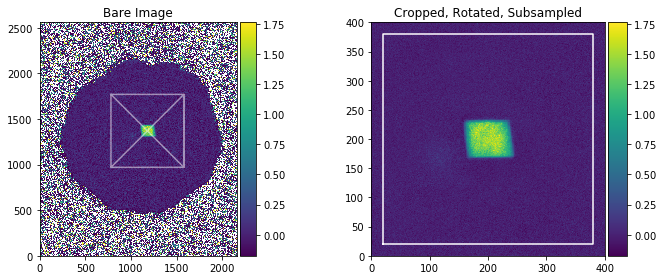

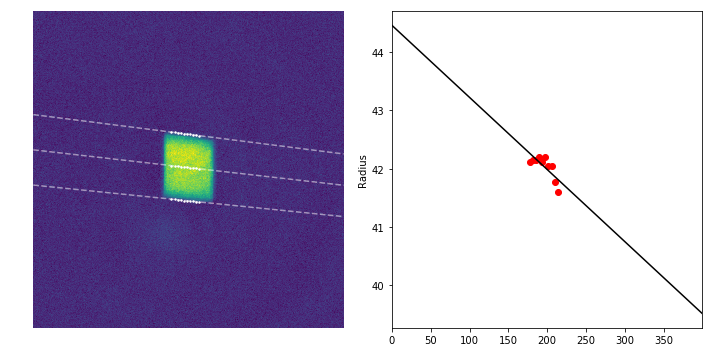

In [701]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1181, center_y = 1370, width=800, height=800, fudge=1.73, subsample=2, 
                  xsec_extension='linear', xsec_slice_width=4, xsec_fit_range=1.0, radial_selection=0.5,)}

# Apply settings
for i, r in df_all.iterrows():
    r.image.set(**settings)
    
# Tests
if WID_info.value: 
    test = 0
    print(df_all.image.iloc[test].name)
    df_all.image.iloc[test].plot_crop()
    print(df_all.x.iloc[test])
    plt.show()
    fig, ax = plt.subplots(ncols=2, figsize=[10, 5])
    df_all.image.iloc[test].xsec.infoplot(axs=ax)
    plt.tight_layout()


All Images 61; Data 28; BG 18
Fudge   1.73
Volume  1010674 um^3
Atom #  0.554 +- 0.029 
Density 0.548 +- 0.029 um^-3
E_F     8.54 +- 0.30 kHz
v_F     33.67 um/ms


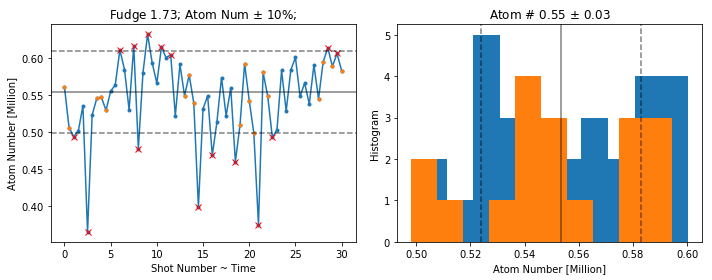

In [702]:
# Atom numbers filter, sort data and bg, print information 

# Parameters 
display(WID_atoms_keep)

df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image, desc='Atoms')]
using = atom_num_filter(df_all, keep=WID_atoms_keep.value, offset=0.0, plot=False)

# Extract data and background 
bg_select = ['ShakingCycles', 0]
df_data = df_all[(df_all[bg_select[0]] != 0) & using]
df_bg = df_all[(df_all[bg_select[0]] == 0) & using]
df_bad = df_all[~using]

# Extract relavant information 
info = {}
info['Images Data'] = df_data.shape[0]
info['Images BG'] = df_bg.shape[0]
info['Fudge'] = df_data.image.iloc[0].fudge
info['Atoms'] = np.mean(df_all[using].total_atoms)
info['Atoms Error'] = np.std(df_all[using].total_atoms)
info['Cross Section Guess'] = np.pi * (59.15e-6)**2
info['Box Length Guess'] = 91.95e-6
info['Volume'] = info['Box Length Guess'] * info['Cross Section Guess']
info['Density'] = info['Atoms'] / info['Volume']
info['Density Error'] = info['Atoms Error'] / info['Volume']
info['EF'] = np.mean(cst.n2EF(df_all[using].total_atoms / info['Volume']))
info['EF Error'] = np.std(cst.n2EF(df_all[using].total_atoms / info['Volume']))
info['vF'] = ((2 * info['EF']) / (cst.mass))**(1/2)

print('All Images {}; Data {}; BG {}'.format(df_all.shape[0], df_data.shape[0], df_bg.shape[0]))
print('Fudge  ', info['Fudge'])
print('Volume  {:.0f} um^3'.format(info['Volume']*1e18))
print('Atom #  {:.3f} +- {:.3f} '.format(info['Atoms']/1e6, info['Atoms Error']/1e6))
print('Density {:.3f} +- {:.3f} um^-3'.format(info['Density']/1e18, info['Density Error']/1e18))
print('E_F     {:.2f} +- {:.2f} kHz'.format(info['EF']/kHz, info['EF Error']/kHz))
print('v_F     {:.2f} um/ms'.format(info['vF'] * 1e3))

if WID_info.value: 
    fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
    ax[0].plot(df_all.shot, df_all.total_atoms/1e6, 'C0.-', 
               df_bad.shot, df_bad.total_atoms/1e6, 'rx',
               df_bg.shot, df_bg.total_atoms/1e6, 'C1.')
    ax[0].axhline(info['Atoms'] / 1e6, linestyle='-', c='k', alpha=0.5)
    ax[0].axhline(info['Atoms'] / 1e6 * (1 + WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax[0].axhline(info['Atoms'] / 1e6 * (1 - WID_atoms_keep.value), linestyle='--', c='k', alpha=0.5)
    ax[0].set(xlabel='Shot Number ~ Time', ylabel='Atom Number [Million]', 
              title='Fudge {}; Atom Num $\pm$ {:.0f}%;'.format(info['Fudge'], WID_atoms_keep.value*100))
    ax[1].hist(df_data.total_atoms/1e6)
    ax[1].hist(df_bg.total_atoms/1e6)
    ax[1].axvline(info['Atoms'] / 1e6, linestyle='-', c='k', alpha=0.5)
    ax[1].axvline(info['Atoms'] / 1e6 + info['Atoms Error']/1e6, linestyle='--', c='k', alpha=0.5)
    ax[1].axvline(info['Atoms'] / 1e6 - info['Atoms Error']/1e6, linestyle='--', c='k', alpha=0.5)
    ax[1].set(xlabel='Atom Number [Million]', ylabel='Histogram', title='Atom # {:.2f} $\pm$ {:.2f}'.format(info['Atoms']/1e6, info['Atoms Error']/1e6))
    plt.tight_layout()
    plt.show()


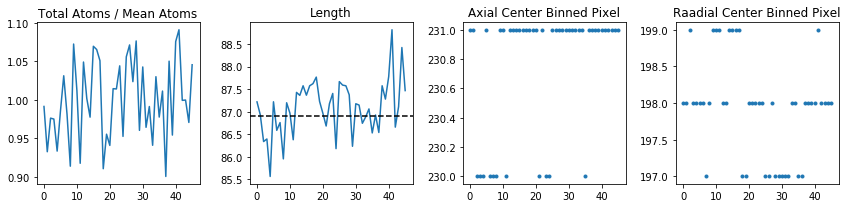

In [703]:
# Get right_edge, length, offset, integral, central_pixel : for all 

# Function definitions 
guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
def fitfun_erf(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
    y = erf(x, x1, s1) + erf(-x, -x2, s2)
    return y*amp/2 + offset + slope*x

# Fitter -- 0:RigthEdge (center), 1:Length, 2:Offset, 3:Integral, 4:RightEdgePixel
subsample = df_bg.iloc[0].image.subsample
def fit_and_extract(nz):
    fr, fe = nz.fit(fitfun_erf, guess, plot=False)
    return [fr[1], fr[1]-fr[0], fr[5], np.trapz(nz.y - fr[5], nz.x), np.argmin(np.abs(nz.x - fr[1]))]

# center and rescale
def center_and_rescale(nz, center, length, offset, rescale):
    return tp.Curve(nz.x - center + length, (nz.y - offset) / np.trapz(nz.y - offset, nz.x) * rescale, 
                    xscale=nz.xscale, yscale=nz.yscale)

# Fit all data 
erf_fit = np.array([fit_and_extract(im.nz) for im in tqdm(df_bg.image)])
df_bg['z_offset'], df_bg['length'], df_bg['n_offset'], df_bg['integral'], df_bg['z_offset_pixel'] = erf_fit.T
erf_fit = np.array([fit_and_extract(im.nz) for im in tqdm(df_data.image)])
df_data['z_offset'], df_data['length'], df_data['n_offset'], df_data['integral'], df_data['z_offset_pixel'] = erf_fit.T

# Calculate radial_center_pixeol
df_bg['radial_center_pixel'] = [np.round(r.image.xsec.get_center(r.z_offset_pixel)) for i, r in df_bg.iterrows()]
df_data['radial_center_pixel'] = [np.round(r.image.xsec.get_center(r.z_offset_pixel)) for i, r in df_data.iterrows()]

# Get averaged length and error 
info['Box Length Fit'] = np.mean(df_bg['length'])
info['nz rescale'] = np.mean(np.concatenate([df_bg['integral'].values, df_data['integral'].values]))

# center and rescale n(z)
df_bg['nz'] = [center_and_rescale(r.image.nz, r.z_offset, info['Box Length Fit'], r.n_offset, info['nz rescale']) for i,r in df_bg.iterrows()]
df_data['nz'] = [center_and_rescale(r.image.nz, r.z_offset, info['Box Length Fit'], r.n_offset, info['nz rescale']) for i,r in df_data.iterrows()]

# Plot the scatter 
plt.figure(figsize=[12, 3])
plt.subplot(141)
plt.plot(np.concatenate([df_bg['integral'].values, df_data['integral'].values]) / info['nz rescale'])
plt.title('Total Atoms / Mean Atoms')
plt.subplot(142)
plt.plot(np.concatenate([df_bg['length'].values, df_data['length'].values])*1e6, '-')
plt.axhline(info['Box Length Fit']*1e6, c='k', linestyle='--')
plt.title('Length')
plt.subplot(143)
plt.plot(np.concatenate([df_bg['z_offset_pixel'].values, df_data['z_offset_pixel'].values]), '.')
plt.title('Axial Center Binned Pixel')
plt.subplot(144)
plt.plot(np.concatenate([df_bg['radial_center_pixel'].values, df_data['radial_center_pixel'].values]), '.')
plt.title('Raadial Center Binned Pixel')
plt.tight_layout()

In [708]:
plot_xi = -10

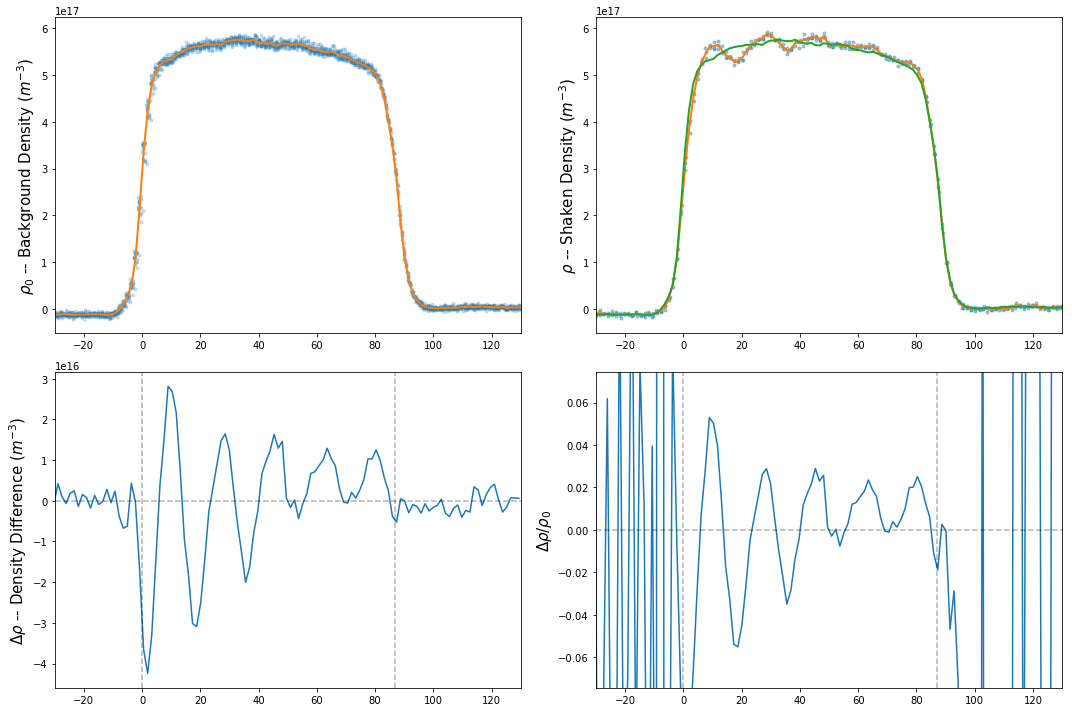

In [709]:
# Average Profiles  

# Inputs
z_lims = np.array([-40, 130]) * 1e-6

# Background 
nz_bg_conc = tp.Curve(np.concatenate([nz.x for nz in df_bg.nz]), np.concatenate([nz.y for nz in df_bg.nz]), 
                      xscale=1e-6, yscale=1).sortbyx()
nz_bg = nz_bg_conc.binbyx(step = np.diff(df_bg.iloc[0].nz.x)[0])

# Raw Data 
x_list = df_data.x.values
z_list = nz_bg.trim(xlim = z_lims).x.copy()
movie_dN_raw = [x_list, z_list*1e6, 
                np.array([nz_data(z_list) - nz_bg(z_list) for nz_data in df_data.nz]).T]
movie_dN_N_raw = [x_list, z_list*1e6, 
                  np.array([(nz_data(z_list) - nz_bg(z_list)) / (nz_bg(z_list)) for nz_data in df_data.nz]).T]

# Average Data 
x_list = np.unique(df_data.x.values)
z_list = nz_bg.trim(xlim = z_lims).x.copy()
nz_data_conc = []
nz_data = []
movie_dN = []
movie_dN_N = []

for x in x_list:
    # Grab the relevant data 
    df_ = df_data[df_data.x == x]
    
    # Average n(z)
    nz_data_conc.append(tp.Curve(np.concatenate([nz.x for nz in df_.nz]), np.concatenate([nz.y for nz in df_.nz]), 
                      xscale=1e-6, yscale=1).sortbyx())
    nz_data.append(nz_data_conc[-1].binbyx(step = np.diff(df_bg.iloc[0].nz.x)[0]))
    
    # Get dN and dN/N
    movie_dN.append( (nz_data[-1](z_list) - nz_bg(z_list)) )
    movie_dN_N.append( (nz_data[-1](z_list) - nz_bg(z_list)) / (nz_bg(z_list)) )

movie_dN = [x_list, z_list*1e6, np.array(movie_dN).T]
movie_dN_N = [x_list, z_list*1e6, np.nan_to_num(np.array(movie_dN_N).T)]


# plot 
xi = plot_xi
plt.figure(figsize=[15, 10])
ax1 = plt.subplot(221)
plt.plot(*nz_bg_conc.plotdata, '.', alpha=0.2)
plt.plot(*nz_bg.plotdata, '-', linewidth=2)
plt.ylabel(r'$\rho_0$ -- Background Density ($m^{-3}$)', fontsize=15)

ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
plt.plot(*nz_data_conc[xi].plotdata, '.', alpha=0.4)
plt.plot(*nz_data[xi].plotdata, '-', linewidth=2)
plt.plot(*nz_bg.plotdata, '-', linewidth=2)
# plt.ylim([nz_bg.plotdata[1].max() * 0.5, None])
plt.ylabel(r'$\rho$ -- Shaken Density ($m^{-3}$)', fontsize=15)

ax3 = plt.subplot(223, sharex = ax1)
plt.plot(movie_dN[1], movie_dN[2][:, xi])
plt.axhline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', alpha=0.3)
plt.ylabel(r'$\Delta \rho$ -- Density Difference ($m^{-3}$)', fontsize=15)

ax4 = plt.subplot(224, sharex = ax1)
plt.plot(movie_dN_N[1], movie_dN_N[2][:, xi])
plt.axhline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(0, c='k', linestyle='--', alpha=0.3)
plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', alpha=0.3)
appx_amp = np.abs(movie_dN_N[2][(movie_dN_N[1]>5) & (movie_dN_N[1]<50), xi]).max() * 1.35
plt.ylim([- appx_amp, appx_amp])
plt.ylabel(r'$\Delta \rho / \rho_0$', fontsize=15)

plt.xlim([-30, 130])

plt.tight_layout()

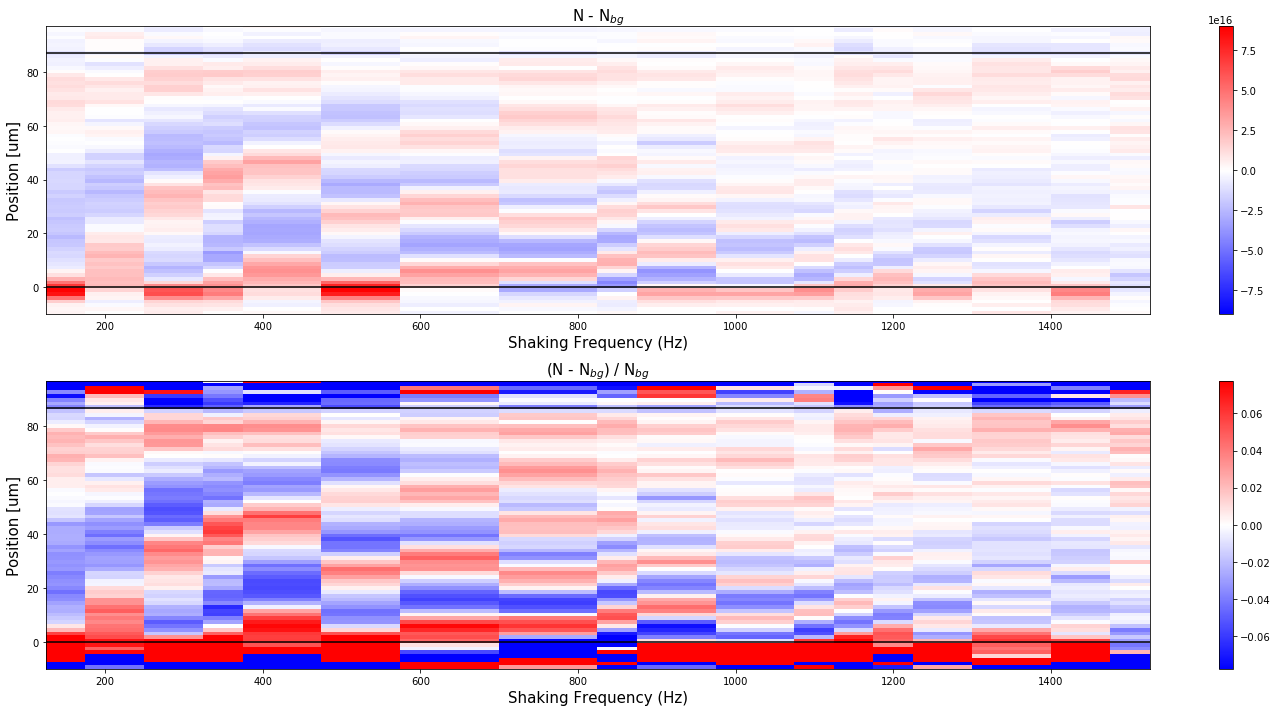

In [706]:
# Generate 1D density for all, and normalize mean of values so the peak is around 1 

# Plot 
cmap = 'bwr' # viridis, bwr
zlim_pad = [-10, 10]
clim_dN_N_pad = 1.2

# Data 
x, y = movie_dN[0:2]
L = info['Box Length Fit']*1e6
clim_dN = np.max(np.abs(movie_dN[2]))
clim_dN_N = np.max(np.abs( movie_dN_N[2][(y>10) & (y<(L-10)), :] )) * clim_dN_N_pad

if len(x) > 1:
    fig = plt.figure(figsize=[20, 10])
    plt.subplot(211)
    plt.pcolormesh(*mesh_for_2d_plot(*movie_dN), vmin=- clim_dN , vmax=clim_dN, cmap=cmap)
    plt.axhline(0, c='k', linestyle='-', )
    plt.axhline(L, c='k', linestyle='-', )
    plt.colorbar()
    plt.title(r'N - N$_{bg}$', fontsize=fontsize)
    plt.ylabel('Position [um]', fontsize=fontsize)
    plt.xlabel(WID_xlabel.value, fontsize=fontsize)
    plt.ylim([zlim_pad[0], zlim_pad[1]+L])
    plt.subplot(212)
    plt.pcolormesh(*mesh_for_2d_plot(*movie_dN_N), vmin=- clim_dN_N, vmax=clim_dN_N, cmap=cmap)
    plt.axhline(0, c='k', linestyle='-', )
    plt.axhline(L, c='k', linestyle='-', )
    plt.colorbar()
    plt.xlabel(WID_xlabel.value, fontsize=fontsize)
    plt.ylabel('Position [um]', fontsize=fontsize)
    plt.ylim([zlim_pad[0], zlim_pad[1]+L])
    plt.title(r'(N - N$_{bg}$) / N$_{bg}$', fontsize=fontsize)
    plt.tight_layout()

# plot single 
if len(x) == 1:
    x, y, z = movie_dN
    plt.plot(y, z)
    plt.axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axhline(0, c='k', linestyle='-', alpha=0.5)
    
    

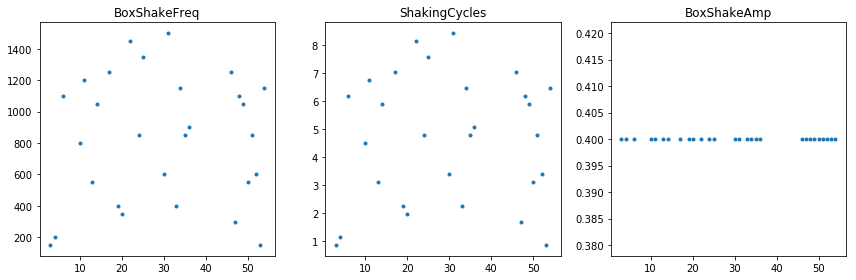

In [707]:
track = ['BoxShakeFreq', 'ShakingCycles', 'BoxShakeAmp', ]

ax = plt.subplots(ncols=len(track), figsize=[4 * len(track), 4])[1].flatten()
for i, t in enumerate(track):
    ax[i].plot(df_data[t], '.')
    ax[i].set(title=t)
plt.tight_layout()

## Single Sided Decay Fits

In [649]:
# Dataset Info 
speed_sound_guess = 17 * 1e-6/1e-3

In [650]:
# Single Sided Fit -- 0:DecayLength, 1:Wavelength, 2:Amplitude, 3:Phase, 4:Offset, 5:Gradient, 6:speed, 7:gamma 
def single_analyzer(c, freq, fit_lims, guess_wavelength, plot=False, plot_lims=[-10, 100]): 
    # Fit Exp Decay 
    guess = [30, guess_wavelength, 0.05, 0, 1e-2, 1e-4,]
    
    # Define Fit function 
    fit_vars = ['Decay Length [um]', 'Wavelength [um]', 'Amplitude at origin', 'Phase at Origin', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    speed_sound = [freq * fr[1] * 1e-6, freq * fe[1] * 1e-6]
    gamma = [speed_sound[0] / fr[0] / 1e-6, ((speed_sound[1] / (fr[0]*1e-6))**2 + (speed_sound[0] * fe[0] * 1e-6 / (fr[0]*1e-6)**2)**2)**(1/2)]
    
    # Print fit results 
    if plot:
        for i in range(fr.shape[0]):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))

    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
        amp = fr[2] * 2
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.tight_layout()

    # return resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    fr[3] = np.mod(fr[3], twopi)
    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

### Fit Averaged

-------------- 0.1 --------------
Decay Length [um] 	 30.1 +- 41.9
Wavelength [um] 	 8.44 +- 0.527
Amplitude at origin 	 0.00279 +- 0.00351
Phase at Origin 	 -0.742 +- 1.25
Offset           	 0.00221 +- 0.00104
Gradient          	 -7.47e-05 +- 2.38e-05

Speed of Sound   16.88 +- 1.05 um/ms
Decay Rate Gamma 89.28 +- 124.44 Hz


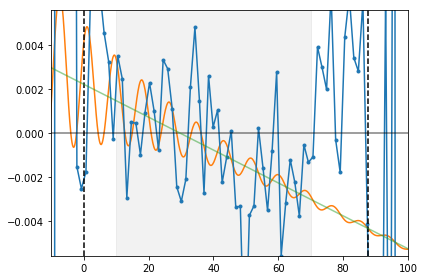

IndexError: index 1 is out of bounds for axis 0 with size 1

In [631]:
# Fit and plot all data 
frs = []
fes = []
fit_lims = [10, 70]
plot_lims = [-10, 100]
freq = np.unique(df_data['BoxShakeFreq'])[0]
movie = movie_dN_N
wavelength_guess = speed_sound_guess / freq


for i in range(num_plots):
    print('-------------- {} --------------'.format(movie[0][i]))
    c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
    fr, fe = single_analyzer(c, freq, fit_lims, wavelength_guess*1e6, True, plot_lims)
    frs.append(fr)
    fes.append(fe)
    plt.show()
    
frs = np.array(frs)
fes = np.array(fes) 

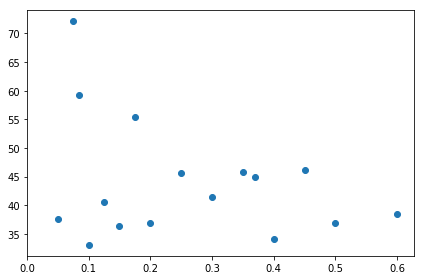

In [419]:
# Plot Raw Results 
plot_res = 0

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(*bin_data(movie[0], frs[:, plot_res]/scales[plot_res])[0:3], fmt='o')
plt.plot(movie[0], frs[:, plot_res]/scales[plot_res], '.', alpha=0.25)
# plt.ylim([0, None])
plt.xlim([0, None])
plt.tight_layout()

### Fit Raw

In [713]:
# Fit and plot all data 
frs = []
fes = []
fit_lims = [10, 70]
plot_lims = [-10, 100]
freq = np.unique(df_data['BoxShakeFreq'])[0]
movie = movie_dN_N_raw
wavelength_guess = speed_sound_guess / freq


for i in range(len(movie[0])):
    c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
    fr, fe = single_analyzer(c, freq, fit_lims, wavelength_guess*1e6, False, plot_lims)
    frs.append(fr)
    fes.append(fe)
    
frs = np.array(frs)
fes = np.array(fes)   

CAN'T FIT, Returning Original Guess: Details of Error Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
CAN'T FIT, Returning Original Guess: Details of Error Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


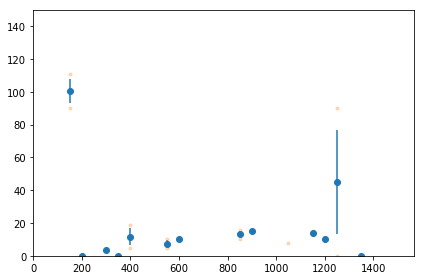

In [714]:
# Plot Raw Results 
plot_res = 7

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(*bin_data(movie[0], frs[:, plot_res]/scales[plot_res])[0:3], fmt='o')
plt.plot(movie[0], frs[:, plot_res]/scales[plot_res], '.', alpha=0.25)
plt.ylim([0, 150])
plt.xlim([0, None])
plt.tight_layout()

### Plots

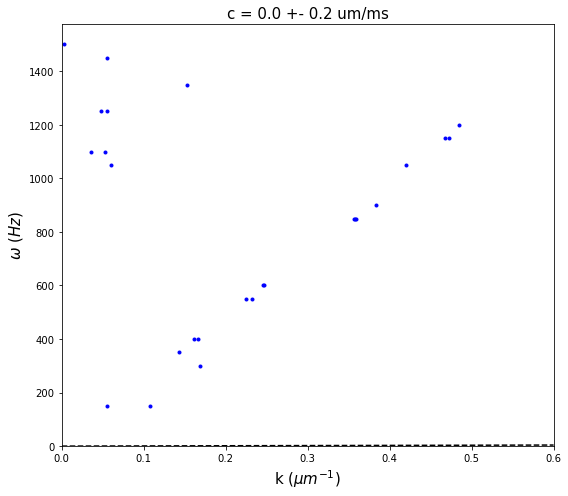

In [716]:
# omega vs k 
binned = bin_data(movie[0], twopi/frs[:, 1])
c = tp.Curve(binned[1], binned[0])
line = lambda x, m:  m*x
fr, fe = c.fit(line, [0,], plot=False)

plt.figure(figsize=(8, 7))
plt.plot(twopi/frs[:, 1], movie[0], 'b.')
plt.plot(np.linspace(0, 0.6, 100), line(np.linspace(0, 0.6, 100), fr[0]), 'k--')
plt.ylim([0, None])
plt.xlim([0, 0.6])
plt.ylabel(r'$\omega$ ($Hz$)', fontsize=15)
plt.xlabel(r'k $(\mu m^{-1})$', fontsize=15)
plt.title('c = {:.1f} +- {:.1f} um/ms'.format(fr[0]*twopi/1e3, fe[0]*twopi/1e3), fontsize=15)
plt.tight_layout()

## FT

In [634]:
# FT Setup 
L = info['Box Length Fit']
k = np.arange(0, 50*twopi/L, 0.1*twopi/L)
movie = movie_dN_N
z_lims = np.array([15, 70]) * 1e-6

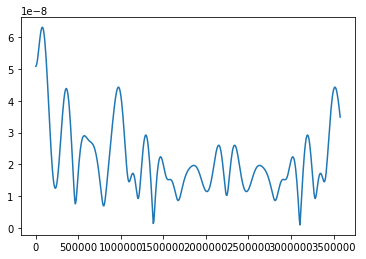

In [639]:
# Test 
test = 0
c = tp.Curve(movie[1] * 1e-6, movie[2][:, test]).trim(xlim=z_lims)
y_ft = fourier_transform(c, k)
# plt.plot(*c.data)
# plt.axvline(twopi*2000 / speed_sound_guess)
plt.plot(k, np.abs(y_ft))

## For One Sided Decay ONLY

Decay Length [um] 	 11.0 +- 15.1
Wavelength [um] 	 45.3 +- 18.8
Amplitude at origin 	 -0.00047 +- 0.00174
Phase at Origin 	 9.48 +- 2.14
Offset           	 0.00836 +- 0.00141
Gradient          	 0.000517 +- 0.000125

Speed of Sound   45.32 um/ms
Decay Rate Gamma 653.73 Hz


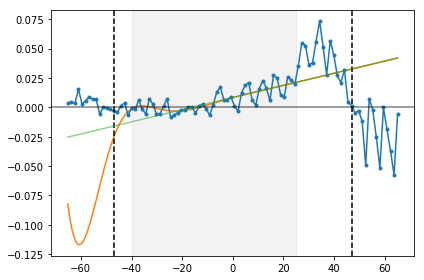

In [206]:
# Fit Exp Decay 
fit_lims = [-40, 25]
guess_c = 15 # um/ms 
guess_wavelength = guess_c / df_data.BoxShakeFreq.iloc[0] * 1e3
guess = [30, guess_wavelength, 0.05, 0, 1e-2, 1e-4,]
# guess = [30, guess_wavelength, 0.05, 0, ]

# Define Fit function 
fit_vars = ['Decay Length [um]', 'Wavelength [um]', 'Amplitude at origin', 'Phase at Origin', 'Offset          ', 'Gradient         ', 'Curvature          ']
def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
    return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

# Prepare and fit data 
trmi_lims = info['Box Length Fit'] * 1e6 * 1.4 / 2
c = tp.Curve(movie_dN[1].flatten(), movie_dN[2].flatten()).trim(xlim=[-trmi_lims, trmi_lims])
fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
speed_sound = df_data.BoxShakeFreq.iloc[0] * fr[1] * 1e-6
gamma = speed_sound / fr[0] / 1e-6 

# Print fit results 
for i in range(fr.shape[0]):
    print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

print('\nSpeed of Sound   {:.2f} um/ms'.format(speed_sound*1e3))
print('Decay Rate Gamma {:.2f} Hz'.format(gamma/twopi))

# Plot Results 
plt.figure()
plt.plot(*c.xyfitplot, 'C1')
plt.plot(*c.plotdata, '.-C0')
plt.axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
plt.axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
plt.axhline(0, c='k', linestyle='-', alpha=0.5)
plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
# plt.ylim([-0.13, 0.13])
plt.tight_layout()

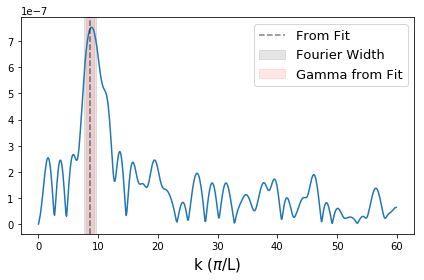

In [94]:
# Fourier Transform 
k0_fit = twopi/(fr[1]*1e-6)
gamma_k_fit = 1/(fr[0]*1e-6)
dN = tp.Curve(movie_dN[1].flatten() * 1e-6, movie_dN[2].flatten(), xscale=1e-6)
L = info['Box Length Fit']
k = np.arange(0, 60 * np.pi/L , 0.1 * np.pi / L)
ft = fourier_transform(dN, k)
dN_f = tp.Curve(k, np.abs(ft), xscale=np.pi/L)

# plt.figure(figsize=[7, 5])
plt.plot(*dN_f.plotdata,)
# plt.plot(dN_f.plotdata[0], np.real(ft), 'C1--', label='Real', alpha=0.3)
# plt.plot(dN_f.plotdata[0], np.imag(ft), 'C2--', label='Imag', alpha=0.3)
plt.axvline(k0_fit / dN_f.xscale, c='k', linestyle='--', alpha=0.5, label='From Fit')
plt.axvspan((k0_fit - np.pi / L) / dN_f.xscale, (k0_fit + np.pi / L) / dN_f.xscale, alpha=0.1, color='k', label='Fourier Width')
plt.axvspan((k0_fit - gamma_k_fit/2) / dN_f.xscale, (k0_fit + gamma_k_fit/2) / dN_f.xscale, alpha=0.1, color='r', label='Gamma from Fit')
plt.legend(fontsize=13)
plt.xlabel(r'k ($\pi$/L)', fontsize=15)
plt.tight_layout()

In [95]:
# # Testing Fourier Transforms 

# T = 10.
# f = 25
# omega = twopi * f
# tau = 0.1
# gamma = 1/tau

# t = np.linspace(0, T, 10000)
# y = np.exp(-t/(2*tau)) * np.cos(omega*t)
# w = np.arange(0, 1000*np.pi/T, 1*np.pi/T)
# y_f = fourier_transform(tp.Curve(t, y), w)
# w_scale = twopi

# fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
# ax[0].plot(t, y)
# ax[1].plot(w/w_scale, np.real(y_f))
# ax[1].axvspan( (omega-gamma/2)/w_scale , (omega+gamma/2)/w_scale , alpha=0.1)
# ax[1].set(xlim=[20,30])

In [96]:
# # Special Waterfall plot  

# plt.figure(figsize=[10, 4])
# plt.subplot(122)
# diff = 0.1
# plt.plot(movie_dN[1], movie_dN[2][:,1] + diff * 0)
# plt.axhline(diff * 0, c='C0', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,3] + diff * 1)
# plt.axhline(diff * 1, c='C1', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,5] + diff * 2)
# plt.axhline(diff * 2, c='C2', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,7] + diff * 3)
# plt.axhline(diff * 3, c='C2', linestyle='--')
# plt.title('# Cycles = 1, 2, 3, 4')

# plt.subplot(121)
# diff = 0.1
# plt.plot(movie_dN[1], movie_dN[2][:,0] + diff * 0)
# plt.axhline(diff * 0, c='C0', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,2] + diff * 1)
# plt.axhline(diff * 1, c='C1', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,4] + diff * 2)
# plt.axhline(diff * 2, c='C2', linestyle='--')
# plt.plot(movie_dN[1], movie_dN[2][:,6] + diff * 3)
# plt.axhline(diff * 3, c='C2', linestyle='--')
# plt.title('# Cycles = 0.5, 1.5, 2.5, 3.5')

# plt.tight_layout()

## For Collection of Single Sided Decay ONLY

In [342]:
def single_analyzer(xi): 
    # Fit Exp Decay 
    fit_lims = [10, 60]
    guess_c = 22 # um/ms 
    guess_wavelength = guess_c / df_data.BoxShakeFreq.iloc[0] * 1e3
    guess = [30, guess_wavelength, 0.05, 0, 1e-2, 1e-4,]
    # guess = [30, guess_wavelength, 0.05, 0, ]

    # Define Fit function 
    fit_vars = ['Decay Length [um]', 'Wavelength [um]', 'Amplitude at origin', 'Phase at Origin', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    trmi_lims = info['Box Length Fit'] * 1e6 * 1.4 / 2
    c = tp.Curve(movie_dN_N[1].flatten(), movie_dN_N[2][:,xi].flatten()).trim(xlim=[-trmi_lims, trmi_lims])
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    speed_sound = [df_data.BoxShakeFreq.iloc[0] * fr[1] * 1e-6, df_data.BoxShakeFreq.iloc[0] * fe[1] * 1e-6]
    gamma = [speed_sound[0] / fr[0] / 1e-6, ((speed_sound[1] / (fr[0]*1e-6))**2 + (speed_sound[0] * fe[0] * 1e-6 / (fr[0]*1e-6)**2)**2)**(1/2)]
    
    # Print fit results 
    for i in range(fr.shape[0]):
        print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

    print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
    print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))

    # Plot Results 
    plt.figure()
    plt.plot(*c.xyfitplot, 'C1')
    plt.plot(*c.plotdata, '.-C0')
    plt.axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
    plt.axhline(0, c='k', linestyle='-', alpha=0.5)
    plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
    plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
    plt.ylim([-0.15, 0.15])
    plt.tight_layout()
    
    # return resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

-------------- 0.05 --------------
Decay Length [um] 	 21.9 +- 6.33
Wavelength [um] 	 23.1 +- 1.1
Amplitude at origin 	 0.0303 +- 0.00962
Phase at Origin 	 2.35 +- 0.319
Offset           	 -0.00599 +- 0.00234
Gradient          	 0.00012 +- 5.92e-05

Speed of Sound   18.48 +- 0.88 um/ms
Decay Rate Gamma 134.58 +- 39.53 Hz


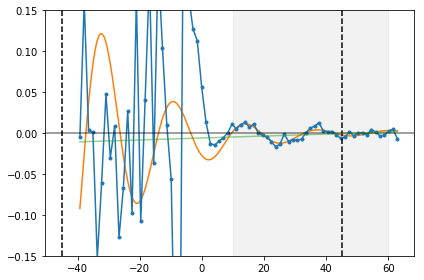

-------------- 0.075 --------------
Decay Length [um] 	 75.6 +- 32.9
Wavelength [um] 	 20.8 +- 0.38
Amplitude at origin 	 0.0179 +- 0.00346
Phase at Origin 	 3.01 +- 0.177
Offset           	 -0.0049 +- 0.00182
Gradient          	 8.76e-05 +- 4.84e-05

Speed of Sound   16.64 +- 0.30 um/ms
Decay Rate Gamma 35.05 +- 15.26 Hz


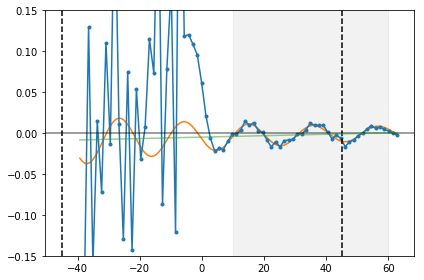

-------------- 0.085 --------------
Decay Length [um] 	 31.4 +- 7.72
Wavelength [um] 	 21.2 +- 0.499
Amplitude at origin 	 0.0302 +- 0.00676
Phase at Origin 	 3.31 +- 0.18
Offset           	 -0.00161 +- 0.00213
Gradient          	 0.000144 +- 5.54e-05

Speed of Sound   16.93 +- 0.40 um/ms
Decay Rate Gamma 85.72 +- 21.16 Hz


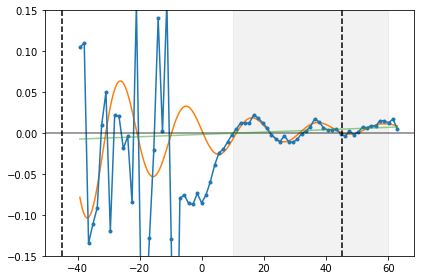

-------------- 0.1 --------------
Decay Length [um] 	 34.0 +- 6.32
Wavelength [um] 	 20.9 +- 0.347
Amplitude at origin 	 0.0347 +- 0.0055
Phase at Origin 	 3.14 +- 0.133
Offset           	 0.000249 +- 0.00187
Gradient          	 -5.44e-05 +- 4.9e-05

Speed of Sound   16.75 +- 0.28 um/ms
Decay Rate Gamma 78.27 +- 14.58 Hz


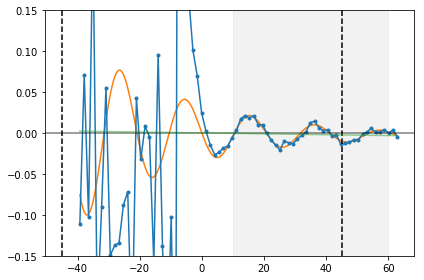

-------------- 0.125 --------------
Decay Length [um] 	 40.2 +- 8.14
Wavelength [um] 	 21.2 +- 0.34
Amplitude at origin 	 0.0363 +- 0.00551
Phase at Origin 	 2.98 +- 0.135
Offset           	 -0.0056 +- 0.00214
Gradient          	 3.84e-05 +- 5.63e-05

Speed of Sound   16.92 +- 0.27 um/ms
Decay Rate Gamma 66.99 +- 13.61 Hz


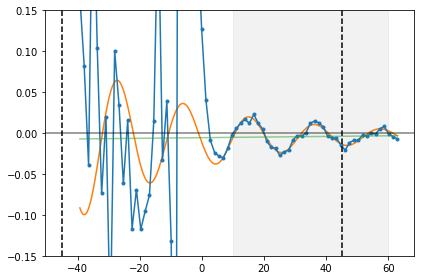

-------------- 0.15 --------------
Decay Length [um] 	 30.7 +- 4.64
Wavelength [um] 	 20.9 +- 0.306
Amplitude at origin 	 0.047 +- 0.00653
Phase at Origin 	 3.17 +- 0.114
Offset           	 -0.00233 +- 0.00204
Gradient          	 -3.59e-05 +- 5.32e-05

Speed of Sound   16.68 +- 0.24 um/ms
Decay Rate Gamma 86.53 +- 13.14 Hz


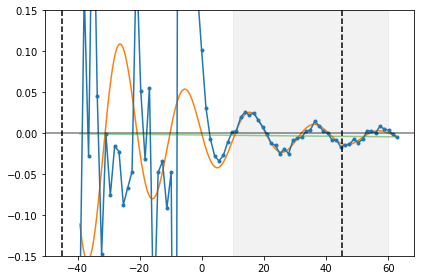

-------------- 0.175 --------------
Decay Length [um] 	 34.9 +- 5.25
Wavelength [um] 	 20.8 +- 0.27
Amplitude at origin 	 0.0549 +- 0.00694
Phase at Origin 	 3.24 +- 0.104
Offset           	 -0.00692 +- 0.00239
Gradient          	 0.000221 +- 6.26e-05

Speed of Sound   16.68 +- 0.22 um/ms
Decay Rate Gamma 75.96 +- 11.46 Hz


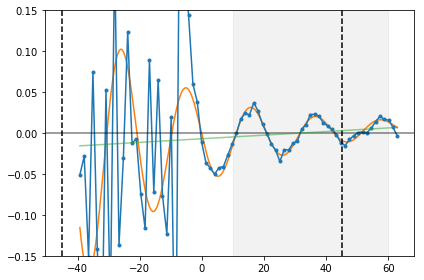

-------------- 0.2 --------------
Decay Length [um] 	 36.5 +- 4.47
Wavelength [um] 	 20.7 +- 0.207
Amplitude at origin 	 0.0581 +- 0.00578
Phase at Origin 	 3.24 +- 0.0824
Offset           	 -0.00906 +- 0.00205
Gradient          	 8.27e-05 +- 5.39e-05

Speed of Sound   16.55 +- 0.17 um/ms
Decay Rate Gamma 72.23 +- 8.88 Hz


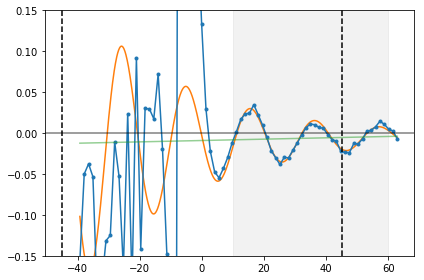

-------------- 0.25 --------------
Decay Length [um] 	 36.6 +- 3.17
Wavelength [um] 	 21.1 +- 0.153
Amplitude at origin 	 0.068 +- 0.00479
Phase at Origin 	 3.22 +- 0.0585
Offset           	 -0.0212 +- 0.00171
Gradient          	 0.000517 +- 4.47e-05

Speed of Sound   16.87 +- 0.12 um/ms
Decay Rate Gamma 73.37 +- 6.37 Hz


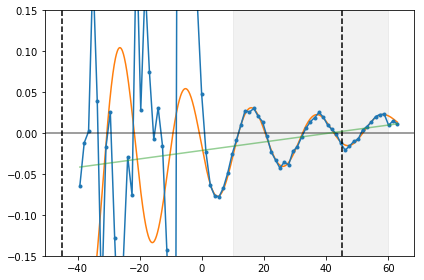

-------------- 0.3 --------------
Decay Length [um] 	 33.9 +- 3.73
Wavelength [um] 	 21.1 +- 0.207
Amplitude at origin 	 0.0764 +- 0.00723
Phase at Origin 	 3.25 +- 0.0774
Offset           	 -0.0191 +- 0.00243
Gradient          	 0.000381 +- 6.35e-05

Speed of Sound   16.84 +- 0.17 um/ms
Decay Rate Gamma 79.01 +- 8.71 Hz


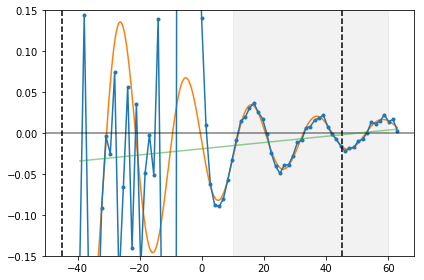

-------------- 0.35 --------------
Decay Length [um] 	 37.6 +- 3.58
Wavelength [um] 	 20.9 +- 0.161
Amplitude at origin 	 0.0825 +- 0.00626
Phase at Origin 	 3.23 +- 0.0632
Offset           	 -0.0249 +- 0.00227
Gradient          	 0.000498 +- 5.97e-05

Speed of Sound   16.70 +- 0.13 um/ms
Decay Rate Gamma 70.74 +- 6.76 Hz


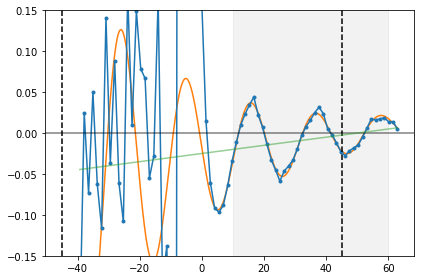

-------------- 0.37 --------------
Decay Length [um] 	 39.2 +- 5.78
Wavelength [um] 	 20.3 +- 0.225
Amplitude at origin 	 0.0789 +- 0.00904
Phase at Origin 	 3.61 +- 0.093
Offset           	 -0.0187 +- 0.00334
Gradient          	 0.000494 +- 8.79e-05

Speed of Sound   16.27 +- 0.18 um/ms
Decay Rate Gamma 66.00 +- 9.75 Hz


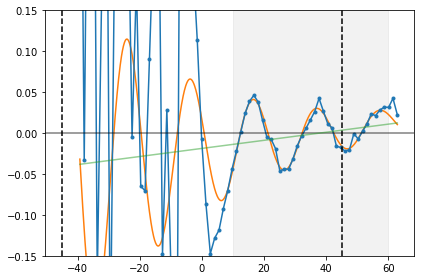

-------------- 0.4 --------------
Decay Length [um] 	 28.5 +- 2.48
Wavelength [um] 	 21.4 +- 0.197
Amplitude at origin 	 0.109 +- 0.00925
Phase at Origin 	 3.2 +- 0.0676
Offset           	 -0.04 +- 0.00268
Gradient          	 0.000803 +- 6.94e-05

Speed of Sound   17.10 +- 0.16 um/ms
Decay Rate Gamma 95.54 +- 8.36 Hz


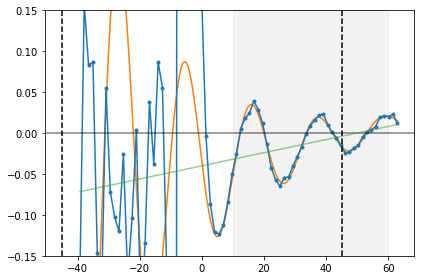

-------------- 0.45 --------------
Decay Length [um] 	 42.6 +- 5.35
Wavelength [um] 	 21.8 +- 0.197
Amplitude at origin 	 0.0905 +- 0.00821
Phase at Origin 	 3.34 +- 0.074
Offset           	 -0.0327 +- 0.00317
Gradient          	 0.000872 +- 8.3e-05

Speed of Sound   17.42 +- 0.16 um/ms
Decay Rate Gamma 65.01 +- 8.18 Hz


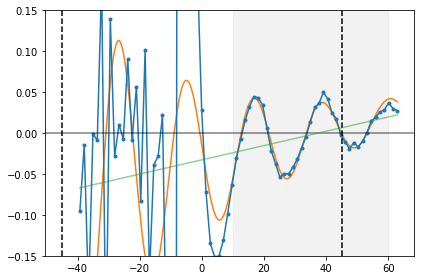

-------------- 0.5 --------------
Decay Length [um] 	 34.3 +- 4.16
Wavelength [um] 	 21.3 +- 0.23
Amplitude at origin 	 0.108 +- 0.0113
Phase at Origin 	 3.48 +- 0.0838
Offset           	 -0.0437 +- 0.00379
Gradient          	 0.00114 +- 9.89e-05

Speed of Sound   17.05 +- 0.18 um/ms
Decay Rate Gamma 79.11 +- 9.64 Hz


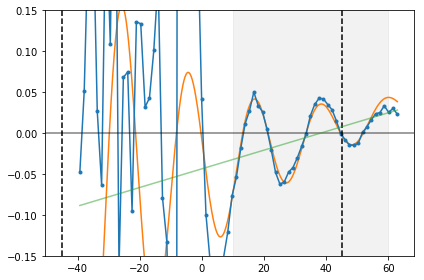

-------------- 0.6 --------------
Decay Length [um] 	 38.0 +- 5.62
Wavelength [um] 	 22.1 +- 0.26
Amplitude at origin 	 0.109 +- 0.0126
Phase at Origin 	 3.48 +- 0.0929
Offset           	 -0.0595 +- 0.00449
Gradient          	 0.00159 +- 0.000117

Speed of Sound   17.66 +- 0.21 um/ms
Decay Rate Gamma 73.96 +- 10.96 Hz


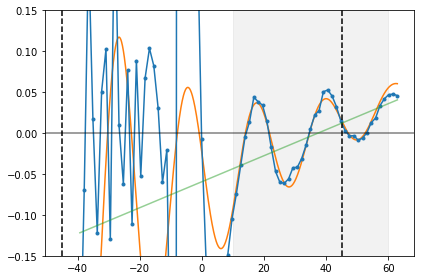

In [343]:
# Fitting 
frs = []
fes = []
for xi in range(movie_dN[0].size):
    print('-------------- {} --------------'.format(movie_dN[0][xi]))
    fr, fe = single_analyzer(xi)
    frs.append(fr)
    fes.append(fe)
    plt.show()
frs = np.array(frs)[3:, :]
fes = np.array(fes)[3:, :]

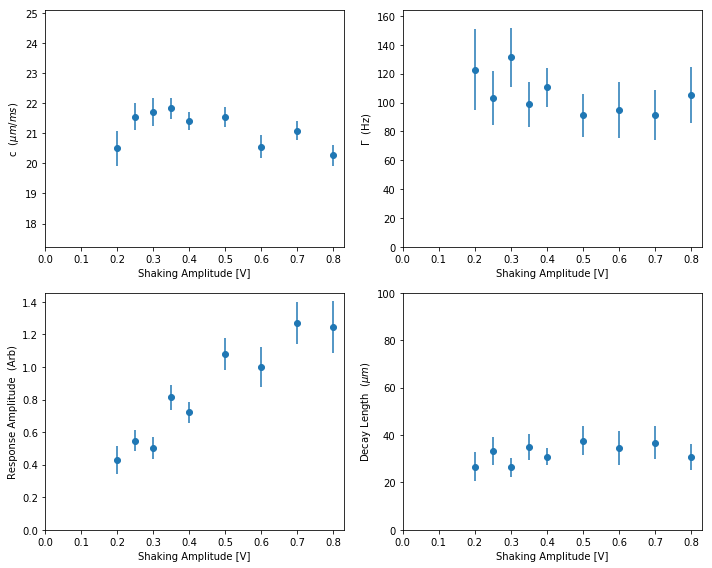

In [549]:
c_lim = [0.85*np.min(frs[:, 6]*1e3), 1.15*np.max(frs[:, 6]*1e3)]
g_lim = [0, 1.25*np.max(frs[:, 7]/twopi)]
l_lim = [0, 100]
x = movie_dN[0].flatten()[3:]
amp_mult = 100/1.45
xp = frs[:, 2]*amp_mult

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[10, 8])
ax = ax.flatten()

ax[0].errorbar(x, frs[:, 6]*1e3, fes[:, 6]*1e3, fmt='o')
ax[0].set(ylabel=r'c  ($\mu m / ms$)', xlim=[0, None], ylim=c_lim, xlabel='Shaking Amplitude [V]')

ax[1].errorbar(x, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o')
ax[1].set(ylabel=r'$\Gamma$  (Hz)', xlim=[0, None], ylim=g_lim, xlabel='Shaking Amplitude [V]')

ax[2].errorbar(x, frs[:, 2]*amp_mult, fes[:, 2]*amp_mult, fmt='o')
ax[2].set(ylabel=r'Response Amplitude  (Arb)', xlim=[0, None], ylim=[0, None], xlabel='Shaking Amplitude [V]')

ax[3].errorbar(x, frs[:, 0], fes[:, 0], fmt='o')
ax[3].set(ylabel=r'Decay Length  ($\mu m$)', ylim=l_lim, xlim=[0, None], xlabel='Shaking Amplitude [V]', )

plt.tight_layout()

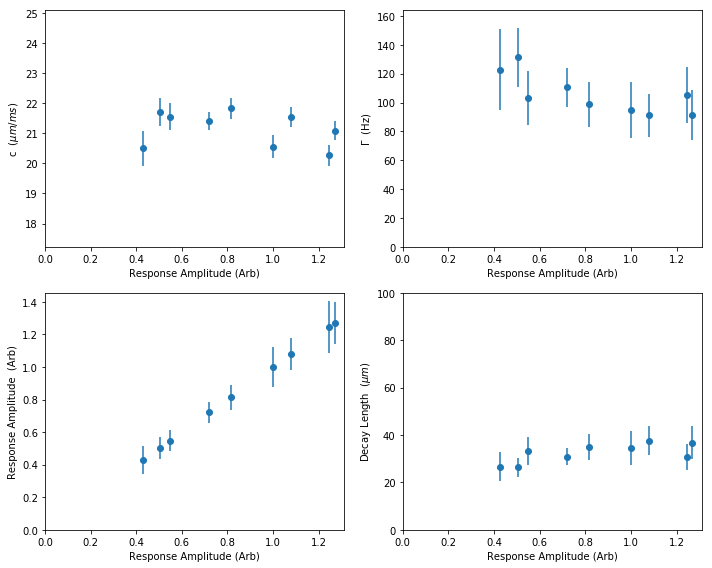

In [550]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[10, 8])
ax = ax.flatten()

ax[0].errorbar(xp, frs[:, 6]*1e3, fes[:, 6]*1e3, fmt='o')
ax[0].set(xlabel = r'Response Amplitude (Arb)', xlim=[0, None], ylabel=r'c  ($\mu m / ms$)', ylim=c_lim)

ax[1].errorbar(xp, frs[:, 7]/twopi, fes[:, 7]/twopi, fmt='o')
ax[1].set(xlabel = r'Response Amplitude (Arb)', xlim=[0, None], ylabel=r'$\Gamma$  (Hz)', ylim=g_lim)

ax[2].errorbar(xp, frs[:, 2]*amp_mult, fes[:, 2]*amp_mult, fmt='o')
ax[2].set(xlabel = r'Response Amplitude (Arb)', xlim=[0, None], ylabel=r'Response Amplitude  (Arb)', ylim=[0, None])

ax[3].errorbar(xp, frs[:, 0], fes[:, 0], fmt='o')
ax[3].set(xlabel = r'Response Amplitude (Arb)', xlim=[0, None], ylabel=r'Decay Length  ($\mu m$)', ylim=l_lim)

plt.tight_layout()

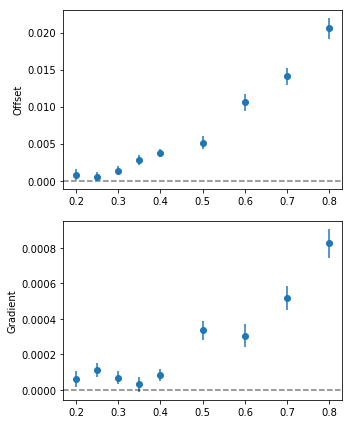

In [551]:
plt.figure(figsize=[5, 6])
ax1 = plt.subplot(211)
plt.errorbar(x, frs[:, 4], fes[:,4], fmt='o')
plt.axhline(0, c='k', linestyle='--', alpha=0.5)
plt.ylabel('Offset')
ax2 = plt.subplot(212, sharex=ax1)
plt.errorbar(x, frs[:, 5], fes[:,5], fmt='o')
plt.axhline(0, c='k', linestyle='--', alpha=0.5)
plt.ylabel('Gradient')
plt.tight_layout()

## For Single Sided Decay vs Frequency ONLY

In [334]:
# Define settings 
movie = movie_dN_N
speed_sound_guess = 22 * 1e-6/1e-3
num_plots = movie[0].size
num_cycles = np.array([df_data[df_data.x == f].iloc[0]['ShakingCycles'] for f in movie[0]])
wavelength_guess = speed_sound_guess / movie[0]
fit_lims = [-35, 25]  


In [335]:
# # Simple plot all data 

# fig, ax = plt.subplots(figsize=[6, num_plots * 3], nrows=num_plots, sharex=True)

# for i in range(num_plots):
#     ax[i].plot(movie[1], movie[2][:, i])
#     ax[i].axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
#     ax[i].axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
#     ax[i].axhline(0, c='k', linestyle='-', alpha=0.5)
#     ax[i].axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
#     ax[i].axvspan(fit_lims[0], fit_lims[0] + wavelength_guess[i]*1e6, alpha=0.05, color='r', label='Fourier Width')
#     ax[i].set(ylim=[-0.1, 0.1])
#     ax[i].set_ylabel('{:.0f} Hz  {:.1f} Cycles'.format(movie[0][i], num_cycles[i]), fontsize=15)
    
# plt.tight_layout()

In [338]:
def single_analyzer(c, freq, fit_lims, guess_wavelength, plot=False): 
    # Fit Exp Decay 
    guess = [30, guess_wavelength, 0.05, 0, 1e-2, 1e-4,]
    
    # Define Fit function 
    fit_vars = ['Decay Length [um]', 'Wavelength [um]', 'Amplitude at origin', 'Phase at Origin', 'Offset          ', 'Gradient         ', 'Curvature          ']
    def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, gradient=0, curvature=0):
        return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + gradient*x + curvature*x**2

    # Prepare and fit data 
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=fit_lims, plot=False)
    speed_sound = [freq * fr[1] * 1e-6, freq * fe[1] * 1e-6]
    gamma = [speed_sound[0] / fr[0] / 1e-6, ((speed_sound[1] / (fr[0]*1e-6))**2 + (speed_sound[0] * fe[0] * 1e-6 / (fr[0]*1e-6)**2)**2)**(1/2)]
    
    # Print fit results 
    if plot:
        for i in range(fr.shape[0]):
            print('{} \t {:.3} +- {:.3}'.format(fit_vars[i], fr[i], fe[i]))

        print('\nSpeed of Sound   {:.2f} +- {:.2f} um/ms'.format(speed_sound[0]*1e3, speed_sound[1]*1e3))
        print('Decay Rate Gamma {:.2f} +- {:.2f} Hz'.format(gamma[0]/twopi, gamma[1]/twopi))

    # Plot Results 
    if plot:
        plt.figure()
        plt.plot(*c.xyfitplot, 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(info['Box Length Fit']*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, fitfun_sin_decay(c.x, *[1, 1, 0, *fr[3:]]), 'C2-', alpha=0.5)
        plt.ylim([-0.15, 0.15])
        plt.tight_layout()

    # return resutls 
    if fr[2] < 0:
        fr[2] = - fr[2]
        fr[3] = fr[3] + np.pi
    fr[3] = np.mod(fr[3], twopi)
    return [list(fr)+[speed_sound[0],gamma[0]], list(fe)+[speed_sound[1],gamma[1]]]

-------------- 0.05 --------------
Decay Length [um] 	 12.9 +- 2.08e+04
Wavelength [um] 	 7.58e+04 +- 4.36e+12
Amplitude at origin 	 0.614 +- 3.57e+07
Phase at Origin 	 0.0237 +- 1.36e+06
Offset           	 0.0443 +- 0.804
Gradient          	 -0.00238 +- 0.0226

Speed of Sound   3.79 +- 217851654.56 um/ms
Decay Rate Gamma 46.77 +- 2689859011.68 Hz


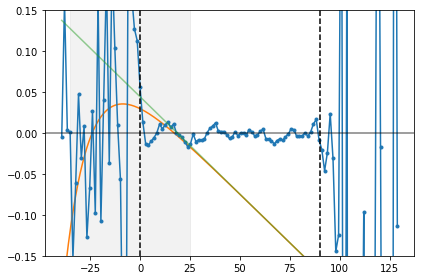

-------------- 0.075 --------------
CAN'T FIT, Returning Original Guess: Details of Error Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


AttributeError: 'list' object has no attribute 'shape'

In [339]:
# Fit and plot all data 
frs = []
fes = []
freqs = []

for i in range(num_plots):
    print('-------------- {} --------------'.format(movie[0][i]))
    c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
    fr, fe = single_analyzer(c, movie[0][i], fit_lims, wavelength_guess[i]*1e6, plot=True)
    frs.append(fr)
    fes.append(fe)
    freqs.append(movie[0][i])
    plt.show()
    
frs = np.array(frs)
fes = np.array(fes)   
freqs = np.array(freqs)

<Container object of 3 artists>

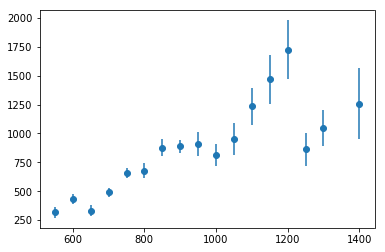

In [1022]:
# Plots 
plot_res = 7
plt.errorbar(freqs, frs[:, plot_res], fes[:, plot_res], fmt='o')

In [1027]:
# Fit and plot all data for various fit_lims 
frs = []
fes = []
freqs = []

fit_lims_various = [[-30, 26], [-33, 26], [-36, 26], [-39, 26],
                    [-30, 23], [-33, 23], [-36, 23], [-39, 23],
                    [-30, 20], [-33, 20], [-36, 20], [-39, 20], ]

for fit_lims in fit_lims_various:
    for i in range(num_plots):
        c = tp.Curve(movie[1].flatten(), movie[2][:, i].flatten())
        fr, fe = single_analyzer(c, movie[0][i], fit_lims, wavelength_guess[i]*1e6,)
        frs.append(fr)
        fes.append(fe)
        freqs.append(movie[0][i])



frs = np.array(frs)
fes = np.array(fes)   
freqs = np.array(freqs)

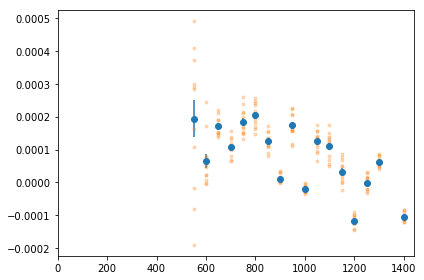

In [1043]:
plot_res = 5

scales = [1, 1, 1, np.pi, 1, 1, 1e-3, twopi]
plt.errorbar(*bin_data(freqs, frs[:, plot_res]/scales[plot_res])[0:3], fmt='o')
plt.plot(freqs, frs[:, plot_res]/scales[plot_res], '.', alpha=0.25)
# plt.ylim([0, None])
plt.xlim([0, None])
plt.tight_layout()

## Save/Load

In [ ]:
# Save Data 

try: WID_SaveAnalyzedDataBtn.on_click(clicked, remove=True)
except: pass

def clicked(btn):
    fname = WID_DatasetType.value + '_' + WID_DatasetDate.value + '_' + WID_DatasetName.value + '_Ver' + __ver__ + '.p'
    p = os.path.join(WID_Folder.value, fname)
    print("Storing File == '{}'".format(p))
    pickle.dump([info, movie_dN, movie_dN_N], open( p, "wb" ) )
    print('Done')
WID_SaveAnalyzedDataBtn.on_click(clicked, remove=False)

display(WID_Folder)
display(WID_DatasetType)
display(WID_DatasetDate)
display(WID_DatasetName)
display(WID_SaveAnalyzedDataBtn)

# Pickle Load
# info, movie_dN, movie_dN_N = pickle.load( open( "20170622_DS3.p", "rb" ) )

In [ ]:
# Load Data -- Single 
data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_06_22_2017_DS3_Ver01.p') # 71.2
data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_07_10_2017_DS1_Ver01.p') # 96
# data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_07_11_2017_DS1_Ver01.p') # 76
# data_filename = os.path.join('AnalyzedData','InsituShakingVsFreq_07_11_2017_DS2_Ver01.p') # 85.9
info, movie_dN, movie_dN_N = pickle.load( open( data_filename, "rb" ) )

# Find approximate 1st mode freq or provide it manually 
res_freq_guess = 85.9

In [ ]:
# Copy to Excel -- Commented Out 

# x_, y_, z_ = movie_dN
# pd.DataFrame(z_, columns=x_, index=y_).to_clipboard(excel=True,)

# x_, y_, z_ = movie_dN_N
# pd.DataFrame(z_, columns=x_, index=y_).to_clipboard(excel=True,)

# pd.DataFrame.from_items([(k,[v]) for k,v in info.items()]).to_clipboard(excel=True)

In [ ]:
# Controllers for clim 
display(WID_clim_dN)
display(WID_clim_dN_N)

## Fourier Transforms

In [597]:
# Only need info, movie_dN, movie_dN_N for futher process 

IndexError: index 1 is out of bounds for axis 0 with size 1

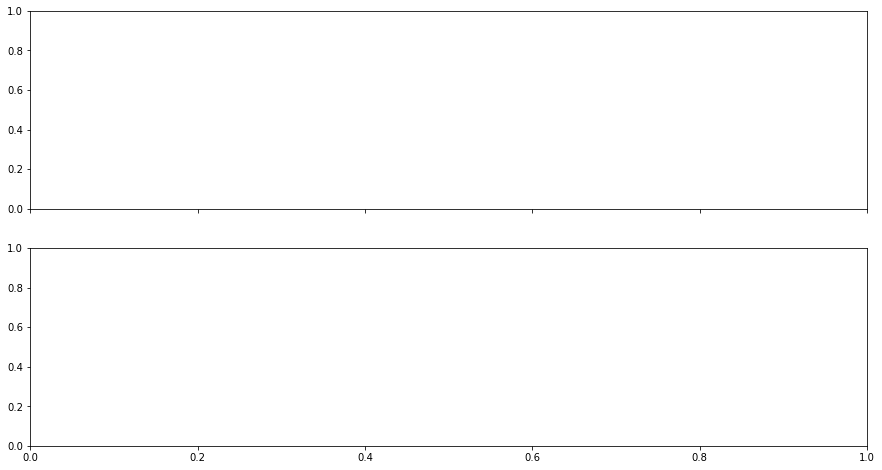

In [598]:
# Spatial FFT Only 

# Data to use 
x, y, z = movie_dN_N
cmap = 'bwr'
xlabel = WID_xlabel.value

# Crop data to end boundaries at the box
L = info['Box Length Fit']
cut = slice(np.argwhere(y<-L/2*1e6)[-1,0]+1, np.argwhere(y>L/2*1e6)[0,0])
y = y[cut]
z = z[cut, :]

# functions 
def compute_k(data, pos):
    return 2*np.pi*np.fft.rfftfreq(data.size, pos[1] - pos[0])
def compute_single_column(data):
    return np.abs(np.fft.rfft(data.flatten()))

# Compute FFT
k = compute_k(z[:,0], y*1e-6)
k_converter = L / np.pi 
z_fft = np.array([compute_single_column(z[:, i]) for i in range(x.size)]).T
movie_1DFFT = (x, k * k_converter, z_fft)

# Plot 
fig, ax = plt.subplots(figsize=[15, 8], nrows=2, sharex=True)
ax[0].pcolormesh(*mesh_for_2d_plot(x, y, z), edgecolor='face', cmap=cmap, vmin=- WID_clim_dN.value , vmax=WID_clim_dN.value)
ax[0].set_ylabel('Position (um)', fontsize=fontsize)
ax[1].pcolormesh(*mesh_for_2d_plot(*movie_1DFFT), edgecolor='face', cmap=cmap)
ax[1].set_xlabel(xlabel, fontsize=fontsize)
ax[1].set_ylabel(r"Wavevector ($\pi$/L)", fontsize=fontsize)
ax[1].set_ylim([0, 17])
ax[1].set_xlim([0,None])

plt.subplots_adjust(hspace=0.03)
plt.tight_layout()
plt.show()

In [ ]:
# Spatial FT Only 

# Data to use 
x, y, z = movie_dN_N
cmap = 'bwr'
xlabel = WID_xlabel.value

# Crop data to end boundaries at the box
L = info['Box Length Fit']
using = 1
cut = slice(np.argwhere(y<-L*using/2*1e6)[-1,0]+1, np.argwhere(y>L*using/2*1e6)[0,0])
y = y[cut]
z = z[cut, :]

# functions 
k = np.arange(0, 20 * np.pi/L , 0.1 * np.pi / L)
k_converter = L / np.pi 
def compute_single_column(data, pos):
    data = data.flatten()
    pos = pos.flatten()
    return np.abs(np.array([np.trapz(data * np.exp(-1j * ki * pos) , pos) for ki in k]))

# Compute FFT
z_fft = np.array([compute_single_column(z[:, i], y*1e-6) for i in range(x.size)]).T
movie_1DFFT = (x, k * k_converter, z_fft)

# Plot 
fig, ax = plt.subplots(figsize=[15, 10], nrows=2, sharex=True)
ax[0].pcolormesh(*mesh_for_2d_plot(x, y, z), edgecolor='face', cmap=cmap, vmin=- WID_clim_dN.value , vmax=WID_clim_dN.value)
ax[0].set_ylabel('Position (um)', fontsize=fontsize)
ax[0].set_title('Fixed Length from erf fit : {:.1f} um'.format(L*1e6) , fontsize=fontsize)
ax[1].pcolormesh(*mesh_for_2d_plot(*movie_1DFFT), edgecolor='face', cmap=cmap)
ax[1].set_xlabel(xlabel, fontsize=fontsize)
ax[1].set_ylabel(r"Wavevector ($\pi$/L)", fontsize=fontsize)
ax[1].set_ylim([0, 17])
ax[1].set_xlim([0,None])
for ymaj in ax[1].yaxis.get_majorticklocs():
    ax[1].axhline(y=ymaj,ls='--', c='w', alpha=0.9)

plt.subplots_adjust(hspace=0.03)
plt.tight_layout()
plt.show()

In [ ]:
# Fits for shaking vs frequency at N or N+1/4 cycles 

# Functions 
def sho_phase(f, f0, gamma):
    f = f * twopi
    f0 = f0 * twopi
    gamma = gamma * twopi
    return np.mod(np.arctan((gamma * f) / (f0**2 - f**2)), np.pi)

def sho_amp(f, f0, gamma, X0=1):
    f = f * twopi
    f0 = f0 * twopi
    gamma = gamma * twopi
    return (f0**2 * X0) / ((f0**2 - f**2)**2 + (gamma*f)**2)**(1/2)

def sho_response(f, f0, gamma, X0, N):
    return sho_amp(f, f0, gamma, X0) * np.sin(twopi * N - sho_phase(f, f0, gamma))

def fitfun_single_abs(f, f0, gamma, X0):
    return sho_response(f, f0, gamma, X0, N=0)

def fitfun_single_dis(f, f0, gamma, X0):
    return sho_response(f, f0, gamma, X0, N=0.25)

def fitfun_all_even_sep_abs(f, a0 = 0, f2=100, g2=10, x2=0, f4=200, g4=10, x4=0, f6=300, g6=10, x6=0, f8=400, g8=10, x8=0, f10=500, g10=10, x10=0, f12=600, g12=10, x12=0):
    y = fitfun_single_abs(f, f2, g2, x2) + fitfun_single_abs(f, f4, g4, x4) + fitfun_single_abs(f, f6, g6, x6) + fitfun_single_abs(f, f8, g8, x8) + fitfun_single_abs(f, f10, g10, x10) + fitfun_single_abs(f, f12, g12, x12)
    return y + a0

def fitfun_all_even_sep_dis(f, a0 = 0, f2=100, g2=10, x2=0, f4=200, g4=10, x4=0, f6=300, g6=10, x6=0, f8=400, g8=10, x8=0, f10=500, g10=10, x10=0, f12=600, g12=10, x12=0):
    y = fitfun_single_dis(f, f2, g2, x2) + fitfun_single_dis(f, f4, g4, x4) + fitfun_single_dis(f, f6, g6, x6) + fitfun_single_dis(f, f8, g8, x8) + fitfun_single_dis(f, f10, g10, x10) + fitfun_single_dis(f, f12, g12, x12)
    return y + a0

def fitfun_all_even_sep_select(*args, **kwargs):
    return fitfun_all_even_sep_abs(*args, **kwargs)
#     return fitfun_all_even_sep_dis(*args, **kwargs)

In [ ]:
# Fit 
xlabel = WID_xlabel.value
clim = WID_clim_dN_N.value
ylabel = 'Response (%)'
fontsize = 15

# Extract data 
x, y, z = movie_dN_N

# central cut 
center = np.argwhere(np.abs(y) == np.min(np.abs(y)))[0,0]
slicer = slice(center - 2, center + 1)
central_cut = tp.Curve(x = x, y = 100 * np.mean(z[slicer, :], 0))
central_cut.removenan()

# Fit central data 
guess = [2, 
         res_freq_guess * 2 , 15 , +2, 
         res_freq_guess * 4 , 50 , -2, 
         res_freq_guess * 6 , 50 , +1.5, 
#          res_freq_guess * 8 , 100 , -1.0, 
#          res_freq_guess * 10, 150 , +0.2, 
#          res_freq_guess * 12, 250, -0.1, 
        ]
fr, fe = central_cut.fit(fitfun_all_even_sep_select, guess, plot=False, xlim=[res_freq_guess*1.25*0, np.inf])
a0 = fr[0]
fr = fr[1:]
fe = fe[1:]
guess = guess[1:]
mode_num = np.arange(0, 2*len(guess)//3, 2) + 2 
fit_sho_all_freq = [mode_num, np.array(fr[0::3]), np.array(fe[0::3])]
fit_sho_all_gamma = [mode_num, np.array(fr[1::3]), np.array(fe[1::3])]
fit_sho_all_amp = [mode_num, np.abs(np.array(fr[2::3])), np.array(fe[2::3])]
fit_sho_all_freq_0 = [mode_num, fit_sho_all_freq[1] / fit_sho_all_freq[0], fit_sho_all_freq[2] / fit_sho_all_freq[0], ]

# Plot 
fig = plt.figure(figsize=[15, 10])
ax1 = plt.subplot(211)
plt.pcolormesh(*mesh_for_2d_plot(x, y, z), vmin=-clim, vmax=clim, cmap='bwr')
plt.axhline(y[slicer.start], c='w', linestyle='--')
plt.axhline(y[slicer.stop-1], c='w', linestyle='--')
plt.ylabel('Position (um)', fontsize=fontsize)
ax2 = plt.subplot(212, sharex=ax1)
plt.axhline(0, c='k', linestyle='-')
plt.axhline(a0, c='k', linestyle='--')
plt.plot(*central_cut.data, '.-')
plt.plot(*central_cut.xyfitplot)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlim([x.min(), x.max()])
plt.tight_layout()

# Plot Fit results
fig = plt.figure(figsize=[15,4])
plt.subplot(131)
plt.errorbar(*fit_sho_all_freq_0, fmt='o')
plt.xlim([0,None])
plt.ylabel('Fundamental Frequency (Hz)', fontsize=fontsize)
plt.subplot(132)
plt.errorbar(*fit_sho_all_gamma, fmt='o')
plt.xlim([0,None])
plt.ylim([0, None])
plt.ylabel('Gamma (Hz)', fontsize=fontsize)
plt.subplot(133)
plt.errorbar(*fit_sho_all_amp, fmt='o')
plt.xlim([0,None])
plt.ylim([0, None])
plt.ylabel('Driving Amplitude (Arb)', fontsize=fontsize)
plt.tight_layout()

## Tests

In [ ]:
# Sum(dN^2)

# Extract data 
x, y, z = movie_dN

# Crop data to end boundaries at the box
L = info['Box Length Fit'] * 0.8
cut = slice(np.argwhere(y<-L/2*1e6)[-1,0]+1, np.argwhere(y>L/2*1e6)[0,0])
y = y[cut]
z = z[cut, :]

# Direct sum of dN
_ = - np.mean(z, axis=0)
direct_sum = tp.Curve(x.flatten(), _.flatten())

# Squared sum of dN
_ = (np.mean(z**2, axis=0))**(1/2)
squared_sum = tp.Curve(x.flatten(), _.flatten())

# Fit sum of lorentzians 
def fitfun_lorentzian_sum(f, offset=0, f1=100, g1=1, a1=0, f2=100, g2=1, a2=0, f3=100, g3=1, a3=0, f4=100, g4=1, a4=0, f5=100, g5=1, a5=0, f6=100, g6=1, a6=0):
    return offset + lorentzian_fitfun(f, f1, g1, a1) + lorentzian_fitfun(f, f2, g2, a2) + lorentzian_fitfun(f, f3, g3, a3) + lorentzian_fitfun(f, f4, g4, a4) + lorentzian_fitfun(f, f5, g5, a5) + lorentzian_fitfun(f, f6, g6, a6)

c = squared_sum
res_freq = res_freq_guess
guess = [c.y.mean(),
         res_freq*2, 10, c.y.max()/1,
         res_freq*4, 30, c.y.max()/2,
         res_freq*6, 50, c.y.max()/4,
#          res_freq*8, 80, c.y.max()/6,
#          res_freq*10, 80, c.y.max()/8,
#          res_freq*12, 100, c.y.max()/10,
        ]
fr, fe = c.fit(fitfun_lorentzian_sum, guess, plot=True, xlim=[100, np.inf])

# Extract Results 
mode_num = (np.arange((len(fr)-1)//3) + 1) * 2
freq = [mode_num, fr[1:][0::3], fe[1:][0::3]]
freq0 = [freq[0], freq[1]/mode_num, freq[2]/mode_num]
gamma = [mode_num, fr[1:][1::3], fe[1:][1::3]]
amp = [mode_num, fr[1:][2::3], fe[1:][2::3]]
offset = [fr[0], fr[0]-fe[0], fr[0]+fe[0]]
offset_plot = [x, x*0 + offset[1], x*0 + offset[2]]

# Plot Results 
fig = plt.figure(figsize=[15, 10])
ax1 = plt.subplot(211)
plt.pcolormesh(*mesh_for_2d_plot(x, y, z), vmin=-clim, vmax=clim, cmap='bwr')
plt.ylabel('Position (um)', fontsize=fontsize)
ax2 = plt.subplot(212, sharex=ax1)
plt.axhline(offset[0], c='k', linestyle='-')
plt.fill_between(*offset_plot, color='k', alpha=0.1)
plt.plot(*c.data, '.-')
plt.plot(*c.xyfitplot)
plt.xlabel(xlabel, fontsize=fontsize)
plt.ylabel(ylabel, fontsize=fontsize)
plt.xlim([x.min(), x.max()])
plt.tight_layout()

# Plot results 
fig = plt.figure(figsize=[15,4])
plt.subplot(131)
plt.errorbar(*freq0, fmt='o')
plt.xlim([0,mode_num[-1]+2])
plt.ylabel('Fundamental Frequency (Hz)', fontsize=fontsize)
plt.subplot(132)
plt.errorbar(*gamma, fmt='o')
plt.xlim([0,mode_num[-1]+2])
plt.ylim([0, None])
plt.ylabel('Gamma (Hz)', fontsize=fontsize)
plt.subplot(133)
plt.errorbar(*amp, fmt='o')
plt.xlim([0,mode_num[-1]+2])
plt.ylim([0, None])
plt.ylabel('Amplitude (Arb)', fontsize=fontsize)
plt.tight_layout()

In [ ]:
# Plot Results 
fig = plt.figure(figsize=[6, 8])
ax1 = plt.subplot(311)
plt.pcolormesh(*mesh_for_2d_plot(x, y, z), vmin=-clim, vmax=clim, cmap='bwr')
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(*c.data, '.-')
ax3 = plt.subplot(313, sharex=ax1)
plt.pcolormesh(*mesh_for_2d_plot(*movie_1DFFT), edgecolor='face', cmap=cmap)
width = 20
center = res_freq_guess
plt.xlim([center-width, center+width])
plt.ylim([0, 5])
plt.tight_layout() 

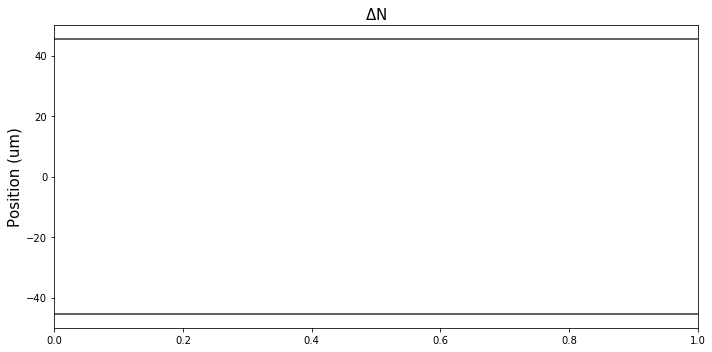

In [609]:
# Spatial FT Only 

# Data to use 
x, y, z = movie_dN
cmap = 'bwr'
xlabel = WID_xlabel.value

# Crop data to end boundaries at the box
L = info['Box Length Fit'] * 1e6

# Plot 
fig, ax = plt.subplots(figsize=[10, 5], nrows=1, sharex=True)
ax.pcolormesh(*mesh_for_2d_plot(x, y, z), edgecolor='face', cmap=cmap, vmin=- WID_clim_dN.value , vmax=WID_clim_dN.value)
ax.set_ylabel('Position (um)', fontsize=fontsize)
ax.set_title(r'$\Delta$N' , fontsize=fontsize)
ax.axhline(L/2, c='k', linestyle='-', alpha=0.8)
ax.axhline(-L/2, c='k', linestyle='-', alpha=0.8)
plt.tight_layout()
plt.show()

# Additional

## Temporary Data Collection 

In [1435]:
# collector = dict()

In [1755]:
datasets = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q', 'R']
heatcycles = np.array([0,10,20,30,40,50,60,70,80,90,5,15,25,35,45, 55,65, 75])

In [1754]:
# collector['R'] = movie_dN

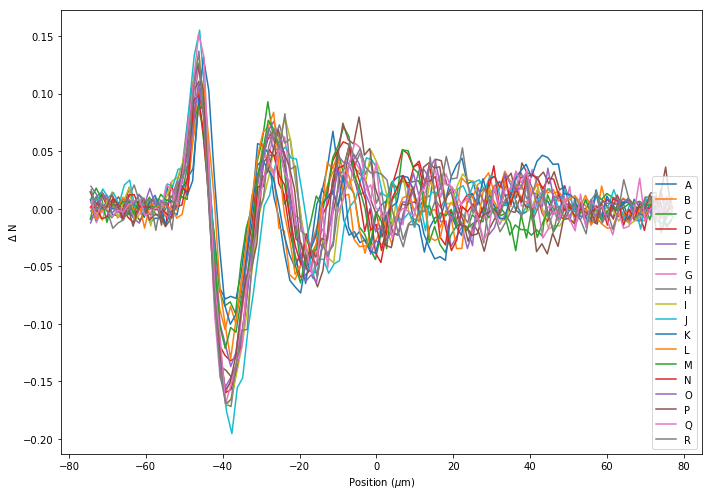

In [1756]:
plt.figure(figsize=[10, 7])
for ds in datasets:
    x, y, z = collector[ds]
    plt.plot(y, z, label=ds)
plt.legend()
plt.ylabel(r'$\Delta$ N')
plt.xlabel(r'Position ($\mu$m)')
plt.tight_layout()

In [2113]:
def fitfun_sin_decay(x, l, wavelength, amp=1, phase = 0, offset=0, slope=0):
    return np.exp(-x/l) * amp * np.sin(2*np.pi/wavelength * x - phase) + offset + slope*x

##______Fit Value______Error______
 0 ==>     32.39 (+-)     4.006
 1 ==>      18.0 (+-)    0.2018
 2 ==>   0.02784 (+-)  0.003982
 3 ==>    -5.104 (+-)     0.143


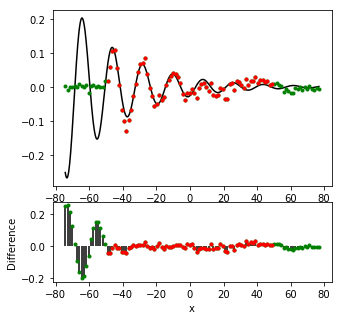

In [1758]:
test = 'L'
guess = [40, 20, 0.03, 0,]
xlim = [-50, 50]
c = tp.Curve(collector[test][1].flatten(), collector[test][2].flatten())#.trim(xlim=[-70, 70])
fr, fe = c.fit(fitfun_sin_decay, guess, xlim=xlim, plot=True)

In [1759]:
frs = []
fes = []
for ds in datasets:
    c = tp.Curve(collector[ds][1].flatten(), collector[ds][2].flatten())#.trim(xlim=[-45, 45])
    fr, fe = c.fit(fitfun_sin_decay, guess, xlim=xlim, plot=False)
    frs.append(fr)
    fes.append(fe)
frs = np.array(frs)
fes = np.array(fes)
shaking_freq = np.unique(df_data.BoxShakeFreq)[0]


# Modify some of the values 
sign = np.sign(frs[:, 2])   # Get the sign of the amplitude
frs[:, 2] = np.abs(frs[:, 2])  # Make the amplitube positive
frs[:, 3] = np.mod(frs[:, 3] - (sign-1) * np.pi/2, twopi) # make the phase between 0 and 2Pi, add pi if amp was negative

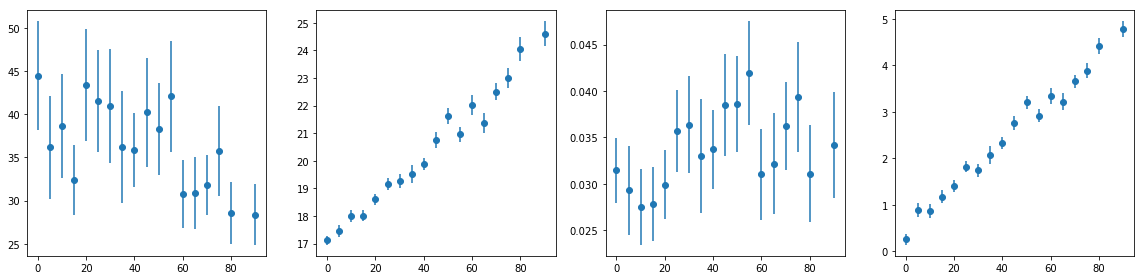

In [1760]:
# Plot all fitres 
fig, ax = plt.subplots(ncols = frs.shape[1], figsize=[4*frs.shape[1], 4])
for i in range(frs.shape[1]):
    ax[i].errorbar(heatcycles, frs[:,i], fes[:,i], fmt='o')
plt.tight_layout()

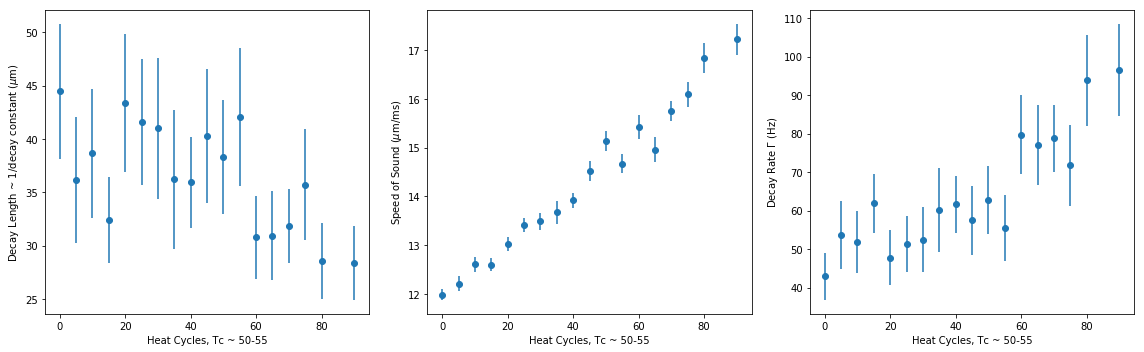

In [1761]:
xlabel='Heat Cycles, Tc ~ 50-55'

decay_length = [heatcycles, frs[:, 0]*1e-6, fes[:, 0]*1e-6]
speed_sound = [heatcycles, shaking_freq * frs[:, 1] * 1e-6, shaking_freq * fes[:, 1] * 1e-6]
decay_rate = [heatcycles, speed_sound[1] / decay_length[1], ((speed_sound[2]/decay_length[1])**2 + (speed_sound[1]/decay_length[1]**2*decay_length[2])**2)**(1/2)]

fig, ax = plt.subplots(ncols=3, figsize=[16, 5])
ax[0].errorbar(decay_length[0], decay_length[1] * 1e6, decay_length[2] * 1e6, fmt = 'o')
ax[0].set(ylabel=r'Decay Length ~ 1/decay constant ($\mu$m)', xlabel=xlabel)
ax[1].errorbar(speed_sound[0], speed_sound[1] * 1e3, speed_sound[2] * 1e3, fmt = 'o')
ax[1].set(ylabel=r'Speed of Sound ($\mu$m/ms)', xlabel=xlabel)
ax[2].errorbar(decay_rate[0], decay_rate[1] / twopi, decay_rate[2] / twopi, fmt='o')
ax[2].set(ylabel=r'Decay Rate $\Gamma$ (Hz)', xlabel=xlabel)
plt.tight_layout()

##______Fit Value______Error______
 0 ==>     48.64 (+-)     25.75
 1 ==>     10.35 (+-)    0.2018
 2 ==>  0.009633 (+-)    0.0028
 3 ==>   -0.0832 (+-)     0.297
 4 ==>  0.004424 (+-)  0.001738
 5 ==>  0.001481 (+-) 8.438e-05

Speed of Sound   15.53 um/ms
Decay Rate Gamma 50.82 Hz


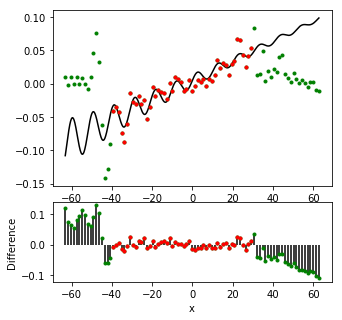

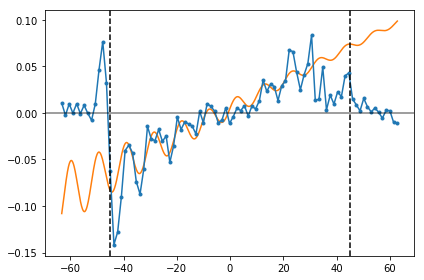

In [2291]:
L = info['Box Length Fit'] * 1e6 * 1.4
c = tp.Curve(movie_dN[1].flatten(), movie_dN[2].flatten()).trim(xlim=[-L/2, L/2])
fr, fe = c.fit(fitfun_sin_decay, [20, 10, 0.05, 0, 0, 0], xlim=[-40,30], plot=True)
# fr, fe = c.fit(fitfun_sin_decay, [40, 20, 0.05, 0,], xlim=[-20,30], plot=True)

speed_sound = df_data.BoxShakeFreq[0] * fr[1] * 1e-6
gamma = speed_sound / fr[0] / 1e-6 
print('\nSpeed of Sound   {:.2f} um/ms'.format(speed_sound*1e3))
print('Decay Rate Gamma {:.2f} Hz'.format(gamma/twopi))

plt.figure()
plt.plot(*c.xyfitplot, 'C1')
plt.plot(*c.plotdata, '.-C0')
plt.axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
plt.axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
plt.axhline(0, c='k', linestyle='-', alpha=0.5)
# plt.ylim([-0.1, 0.1])
plt.tight_layout()

##______Fit Value______Error______
 0 ==>     45.06 (+-)     22.83
 1 ==>     10.37 (+-)     0.209
 2 ==>  0.005537 (+-)  0.001689
 3 ==>  -0.08264 (+-)    0.3118
 4 ==>  0.002448 (+-)  0.001038
 5 ==>  0.000881 (+-) 5.046e-05

Speed of Sound   15.55 um/ms
Decay Rate Gamma 54.92 Hz


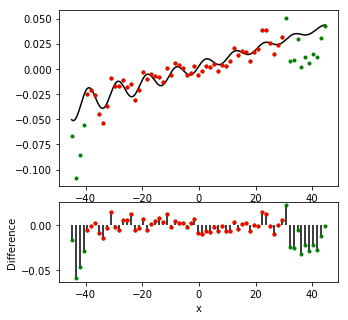

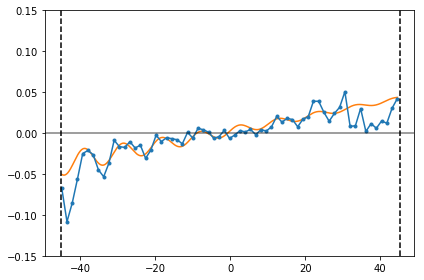

In [2289]:
L = info['Box Length Fit'] * 1e6
c = tp.Curve(movie_dN_N[1].flatten(), movie_dN_N[2].flatten()).trim(xlim=[-L/2, L/2])
fr, fe = c.fit(fitfun_sin_decay, [20, 10, 0.05, 0, 0, 0], xlim=[-40,30], plot=True)
# fr, fe = c.fit(fitfun_sin_decay, [40, 20, 0.05, 0,], xlim=[-20,30], plot=True)

speed_sound = df_data.BoxShakeFreq[0] * fr[1] * 1e-6
gamma = speed_sound / fr[0] / 1e-6 
print('\nSpeed of Sound   {:.2f} um/ms'.format(speed_sound*1e3))
print('Decay Rate Gamma {:.2f} Hz'.format(gamma/twopi))

plt.figure()
plt.plot(*c.xyfitplot, 'C1')
plt.plot(*c.plotdata, '.-C0')
plt.axvline(info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
plt.axvline(-info['Box Length Fit']*1e6/2, c='k', linestyle='--', )
plt.axhline(0, c='k', linestyle='-', alpha=0.5)
plt.ylim([-0.15, 0.15])
plt.tight_layout()

## Estimating # of cycles Needed

In [763]:
c = 22 # um/ms
f = np.arange(500, 1500, 50) # Hz 
max_length = 70 # um
grace_cycle = 0.75 # cycle not included in max_length 

num_cycles = max_length / c * f / 1e3 + grace_cycle

for i in range(len(num_cycles)):
    print('Freq {} \t Num {:.1f}'.format(f[i], num_cycles[i]))

Freq 500 	 Num 2.3
Freq 550 	 Num 2.5
Freq 600 	 Num 2.7
Freq 650 	 Num 2.8
Freq 700 	 Num 3.0
Freq 750 	 Num 3.1
Freq 800 	 Num 3.3
Freq 850 	 Num 3.5
Freq 900 	 Num 3.6
Freq 950 	 Num 3.8
Freq 1000 	 Num 3.9
Freq 1050 	 Num 4.1
Freq 1100 	 Num 4.2
Freq 1150 	 Num 4.4
Freq 1200 	 Num 4.6
Freq 1250 	 Num 4.7
Freq 1300 	 Num 4.9
Freq 1350 	 Num 5.0
Freq 1400 	 Num 5.2
Freq 1450 	 Num 5.4


In [266]:
xsec.get_center(199)

198.49831023444654

In [301]:
xsec = df_bg.iloc[0].image.xsec
df_bg.iloc[0].image.xsec.get_center(199)

198.49831023444654

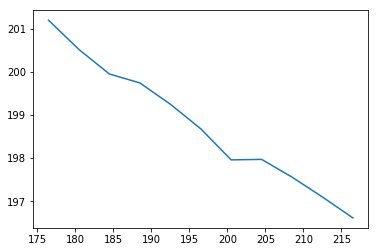

In [302]:
plt.plot(xsec.z_center, xsec.center_fit)